In [ ]:
import dash
from dash import dcc
from dash import html
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

app = dash.Dash(__name__)

# --- Create individual visualization components ---

# Frequência de Diagnóstico por Sintoma
diagnosis_frequency_graphs = []
if 'existing_symptoms' in locals() and existing_symptoms and 'df' in locals():
    symptoms_for_diagnosis_freq = [symptom for symptom in existing_symptoms if symptom != 'Febre']
    for symptom in symptoms_for_diagnosis_freq:
        if symptom in df.columns:
            symptom_present_df = df[df[symptom] == 1]
            if not symptom_present_df.empty:
                diagnosis_counts_for_symptom = symptom_present_df['Diagnóstico'].value_counts().reset_index()
                diagnosis_counts_for_symptom.columns = ['Diagnóstico', 'Contagem']
                fig = px.bar(diagnosis_counts_for_symptom, x='Diagnóstico', y='Contagem',
                             title=f'Contagem de Diagnósticos para o Sintoma: {symptom}')
                diagnosis_frequency_graphs.append(dcc.Graph(figure=fig))
            else:
                 diagnosis_frequency_graphs.append(html.P(f"Sem dados para o sintoma: {symptom}"))

elif 'df' in locals():
    print("existing_symptoms not found or empty. Skipping Diagnosis Frequency by Symptom graphs.")


# Contagem de Diagnósticos
diagnosis_counts_graph = []
if 'diagnosis_counts_df' in locals():
    fig = px.bar(diagnosis_counts_df, x='Diagnóstico', y='Count', title='Contagem de Diagnósticos')
    diagnosis_counts_graph.append(dcc.Graph(figure=fig))
elif 'df' in locals():
     print("diagnosis_counts_df not found. Skipping Diagnosis Counts graph.")


# Distribuição de Variáveis Climáticas e Demográficas
climatic_demographic_graphs = []
if 'variables_to_visualize' in locals() and 'df' in locals():
    for var in variables_to_visualize:
        fig = px.histogram(df, x=var, title=f'Distribuição de {var}', nbins=30)

        mean_value = df[var].mean()
        fig.add_vline(x=mean_value, line_dash="dash", line_color="red", annotation_text=f"Média: {mean_value:.2f}")

        climatic_demographic_graphs.append(dcc.Graph(figure=fig))
elif 'df' in locals():
    print("variables_to_visualize or df not found. Skipping Climatic and Demographic Distribution graphs.")


# Importância das Features
feature_importance_graphs = []
if 'sorted_feature_importances' in locals():
    # All Features Importance
    fig_all = px.bar(sorted_feature_importances.head(15).reset_index(),
                 x='index', y=0,
                 title='Importância das Top 15 Features (Todas)',
                 labels={'index': 'Feature', 0: 'Importância'})
    feature_importance_graphs.append(dcc.Graph(figure=fig_all))

    # Climatic Features Importance
    climatic_features = ['Temperatura (°C)', 'Umidade', 'Velocidade do Vento (km/h)']
    climatic_importance = sorted_feature_importances[sorted_feature_importances.index.isin(climatic_features)]
    if not climatic_importance.empty:
        fig_climate = px.bar(climatic_importance.reset_index(),
                             x='index', y=0,
                             title='Importância das Features Climáticas',
                             labels={'index': 'Feature Climática', 0: 'Importância'})
        feature_importance_graphs.append(dcc.Graph(figure=fig_climate))
    else:
        feature_importance_graphs.append(html.P("Nenhuma feature climática encontrada para importância."))


elif 'df' in locals():
    feature_importance_graphs.append(html.P("sorted_feature_importances não encontrado. Pulando gráficos de Importância das Features."))


# Clima vs. Diagnóstico
climate_diagnosis_graphs = []
if 'climatic_variables' in locals() and 'df' in locals():
    for var in climatic_variables:
        fig = px.box(df, x='Diagnóstico', y=var, title=f'Distribuição de {var} por Diagnóstico')
        fig.update_layout(xaxis={'categoryorder':'category ascending'})
        climate_diagnosis_graphs.append(dcc.Graph(figure=fig))
elif 'df' in locals():
    print("climatic_variables or df not found. Skipping Climate vs. Diagnosis graphs.")


# Clima vs. Sintomas
climate_symptoms_graphs = []
if 'climatic_variables' in locals() and 'symptoms_to_plot' in locals() and 'df' in locals():
    symptoms_to_plot_modified = [symptom for symptom in symptoms_to_plot if symptom not in ['Dor no Peito', 'HIV/AIDS', 'Vômito']]
    climatic_variables_modified = [var for var in climatic_variables if var not in ['Temperatura (°C)', 'Umidade', 'Velocidade do Vento (km/h)']]

    for symptom in symptoms_to_plot_modified:
        if symptom in df.columns:
            df[f'{symptom}_Present'] = df[symptom].apply(lambda x: 'Presente' if x == 1 else 'Ausente')

            for climatic_var in climatic_variables:
                 if not (symptom == 'Dor no Peito' and climatic_var == 'Velocidade do Vento (km/h)') and \
                    not (symptom in ['HIV/AIDS', 'Vômito'] and climatic_var in ['Temperatura (°C)', 'Umidade', 'Velocidade do Vento (km/h)']):

                    fig = px.box(df, x=f'{symptom}_Present', y=climatic_var, title=f'Distribuição de {climatic_var} para {symptom}')
                    climate_symptoms_graphs.append(dcc.Graph(figure=fig))

            df = df.drop(columns=[f'{symptom}_Present'])
        else:
            print(f"Symptom column '{symptom}' not found for Climate vs. Symptoms graphs.")

elif 'df' in locals():
     print("climatic_variables, symptoms_to_plot or df not found. Skipping Climate vs. Symptoms graphs.")


# Matriz de Correlação Quadrada (Climáticas, Demográficas e Sintomas Relevantes - Filtrado)
square_correlation_matrix_graph = []
if 'variables_to_visualize' in locals() and 'sorted_feature_importances' in locals() and 'df' in locals():
    selected_columns = variables_to_visualize.copy()

    top_symptom_names = sorted_feature_importances.head(10).index.tolist()
    relevant_symptoms = [symptom for symptom in top_symptom_names if symptom in df.columns and symptom not in selected_columns]

    variables_to_exclude = ['Gênero', 'Erupções Cutâneas', 'Problemas de Visão', 'Diarreia']

    relevant_symptoms_filtered = [symptom for symptom in relevant_symptoms if symptom not in variables_to_exclude]
    selected_columns_filtered = [col for col in selected_columns if col not in variables_to_exclude]

    climatic_and_demographic_ordered = [col for col in ['Temperatura (°C)', 'Umidade', 'Velocidade do Vento (km/h)', 'Idade'] if col in selected_columns_filtered]
    symptomatic_ordered = relevant_symptoms_filtered

    all_selected_columns = climatic_and_demographic_ordered + symptomatic_ordered


    correlation_df = df[all_selected_columns].copy()

    square_correlation_matrix = correlation_df.corr()

    square_heatmap_fig = go.Figure(data=go.Heatmap(
        z=square_correlation_matrix.values,
        x=square_correlation_matrix.columns,
        y=square_correlation_matrix.index,
        colorscale='Viridis',
        zmin=-1, zmax=1,
        colorbar=dict(title='Correlação')))

    square_heatmap_fig.update_layout(
        title='Matriz de Correlação Quadrada (Climáticas, Demográficas e Sintomas Relevantes - Filtrado)',
        xaxis_title='Variável',
        yaxis_title='Variável',
        xaxis={'categoryorder':'array', 'categoryarray': all_selected_columns},
        yaxis={'categoryorder':'array', 'categoryarray': all_selected_columns}
    )
    square_correlation_matrix_graph.append(dcc.Graph(figure=square_heatmap_fig))

elif 'df' in locals():
    square_correlation_matrix_graph.append(html.P("Variáveis necessárias para a matriz de correlação quadrada não encontradas. Pulando."))


# --- Define the Dashboard Layout ---
app.layout = html.Div(children=[
    html.H1(children='Dashboard de Análise de Dados de Previsão de Doenças Relacionadas ao Clima'),

    html.H2(children='Contagem de Diagnósticos'),
    html.Div(diagnosis_counts_graph),

    html.H2(children='Distribuição de Variáveis Climáticas e Demográficas'),
    html.Div(climatic_demographic_graphs),

    html.H2(children='Frequência de Diagnóstico por Sintoma'),
    html.Div(diagnosis_frequency_graphs),


    html.H2(children='Importância das Features'),
    html.Div(feature_importance_graphs),

    html.H2(children='Clima vs. Diagnóstico'),
    html.Div(climate_diagnosis_graphs),

    html.H2(children='Clima vs. Sintomas'),
    html.Div(climate_symptoms_graphs),

    html.H2(children='Matriz de Correlação Quadrada (Climáticas, Demográficas e Sintomas Relevantes - Filtrado)'),
    html.Div(square_correlation_matrix_graph),

])

try:
    app.run(mode='inline', port=8057)
except Exception as e:
    print(f"Could not run Dash server inline. Error: {e}")
    print("Please ensure you have jupyter_dash installed or try running this code as a standalone Python script.")

<IPython.core.display.Javascript object>

# Task
Perform an exploratory data analysis on the climate-related disease prediction dataset provided in the file "climate_diseases.csv". The analysis should include: counting symptom frequency by diagnosis for four example symptoms, counting the occurrences of each diagnosis, visualizing the distribution of climatic and demographic variables (Age, Temperature, Humidity, Wind Speed), determining feature importance using a simple classification model, showing relationships between climatic variables and diagnoses, visualizing symptom distribution across diagnoses, and showing relationships between climatic variables and selected symptoms. Unify the 'pain_behind_eye' and 'pain_behind_the_eye' columns. Present the findings using clear graphs and tables. Repeat the symptom by diagnosis count analysis at the end.

## Load the dataset

### Subtask:
Load the dataset from the provided file path into a pandas DataFrame.


**Reasoning**:
The first step is to load the dataset into a pandas DataFrame, so I will import pandas and read the CSV file.



In [ ]:
import pandas as pd

df = pd.read_csv('/content/DATASET FINAL WRDP.csv')
df.head()

,Idade,Gênero,Temperatura (°C),Umidade,Velocidade do Vento (km/h),Náusea,Dor nas Articulações,Dor Abdominal,Febre Alta,Calafrios,...,Dor Facial,Falta de Ar,Redução de Olfato e Paladar,Irritação na Pele,Coceira,Dor de Cabeça Pulsante,Confusão Mental,Dor nas Costas,Dor no Joelho,Diagnóstico
0,4,1,25.826,0.740000,8.289000,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Heart Attack
1,55,0,21.628,0.600000,15.236000,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Influenza
2,45,0,13.800,0.817083,4.291992,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Influenza
3,6,0,37.254,0.610000,18.009000,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Dengue
4,70,0,18.162,0.870000,17.916000,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Sinusitis


## Data cleaning

### Subtask:
Unify the 'pain_behind_eye' and 'pain_behind_the_eye' columns into a single column.


**Reasoning**:
Unify the 'pain_behind_eye' and 'pain_behind_the_eye' columns into a single column by checking for their existence, creating the new column, and dropping the original columns.



In [ ]:
if 'pain_behind_eye' in df.columns and 'pain_behind_the_eye' in df.columns:
    df['pain_behind_eye_unified'] = df[['pain_behind_eye', 'pain_behind_the_eye']].max(axis=1)
    df = df.drop(columns=['pain_behind_eye', 'pain_behind_the_eye'])

display(df.head())

,Idade,Gênero,Temperatura (°C),Umidade,Velocidade do Vento (km/h),Náusea,Dor nas Articulações,Dor Abdominal,Febre Alta,Calafrios,...,Dor Facial,Falta de Ar,Redução de Olfato e Paladar,Irritação na Pele,Coceira,Dor de Cabeça Pulsante,Confusão Mental,Dor nas Costas,Dor no Joelho,Diagnóstico
0,4,1,25.826,0.740000,8.289000,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Heart Attack
1,55,0,21.628,0.600000,15.236000,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Influenza
2,45,0,13.800,0.817083,4.291992,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Influenza
3,6,0,37.254,0.610000,18.009000,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Dengue
4,70,0,18.162,0.870000,17.916000,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Sinusitis


## Count symptom by diagnosis

### Subtask:
Select four example symptoms and visualize their frequency within each diagnosis category using bar charts.


**Reasoning**:
Select four symptom columns and calculate the frequency of each symptom per diagnosis, then visualize the results using bar charts.



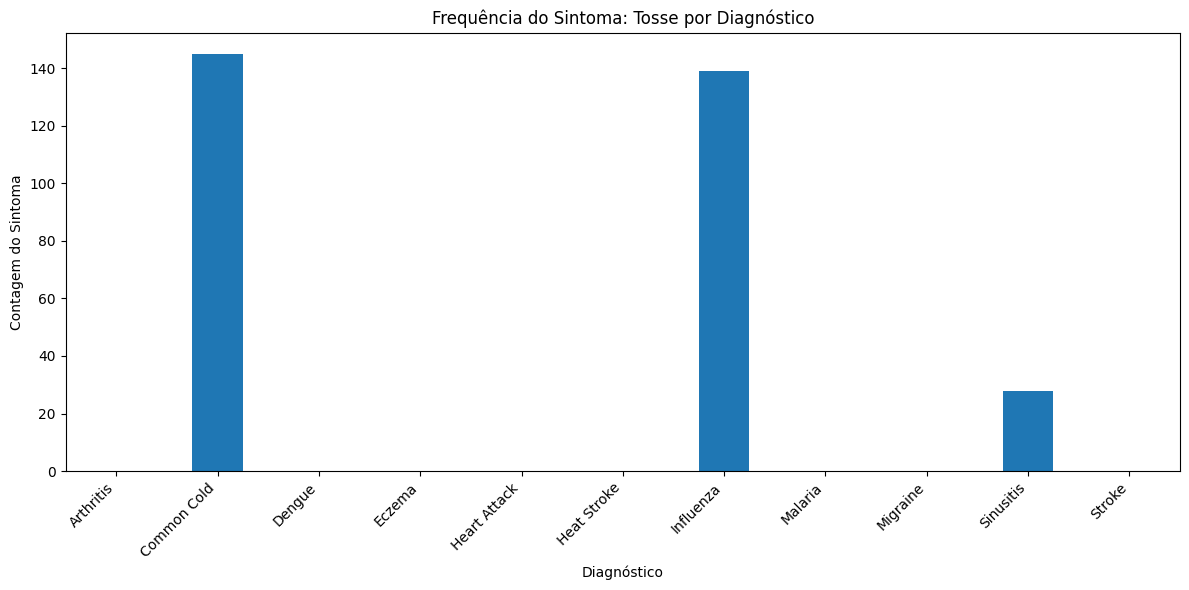

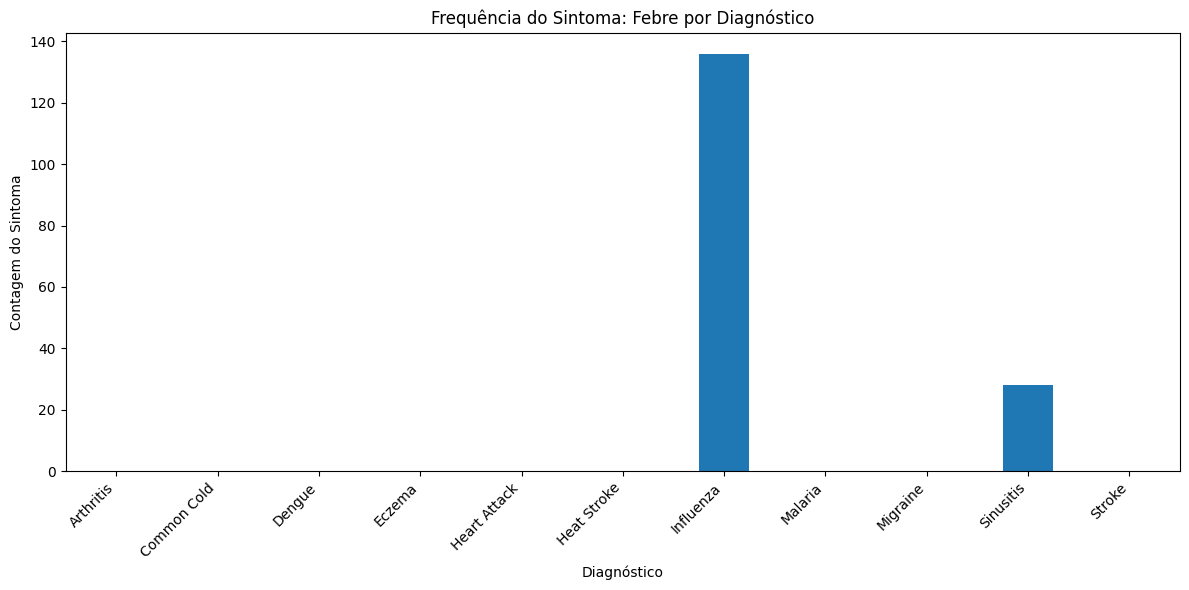

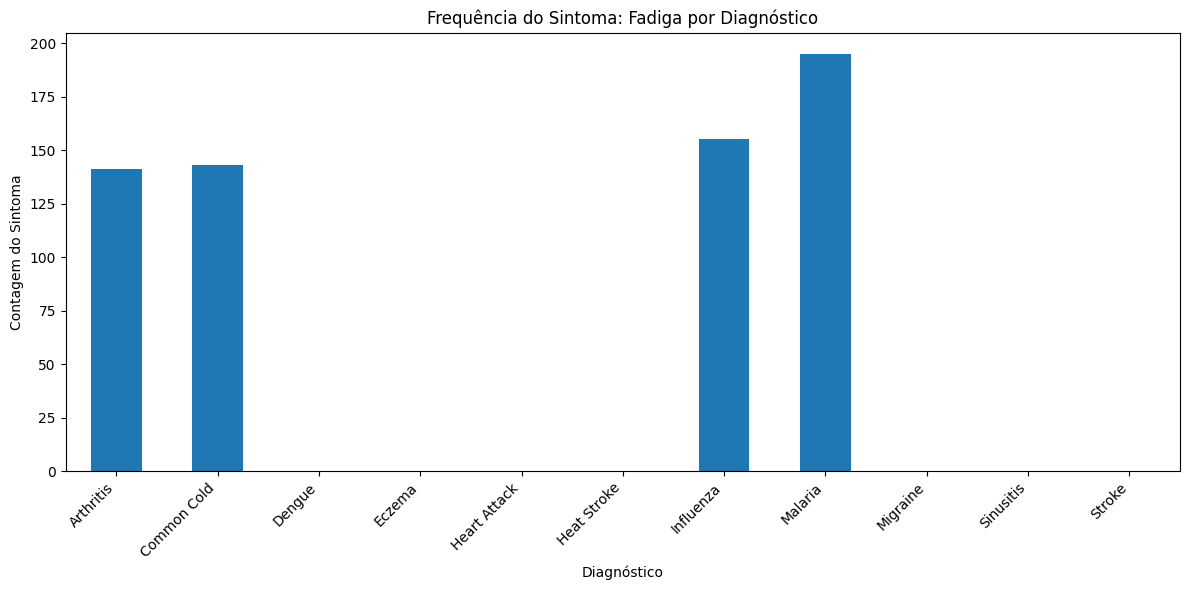

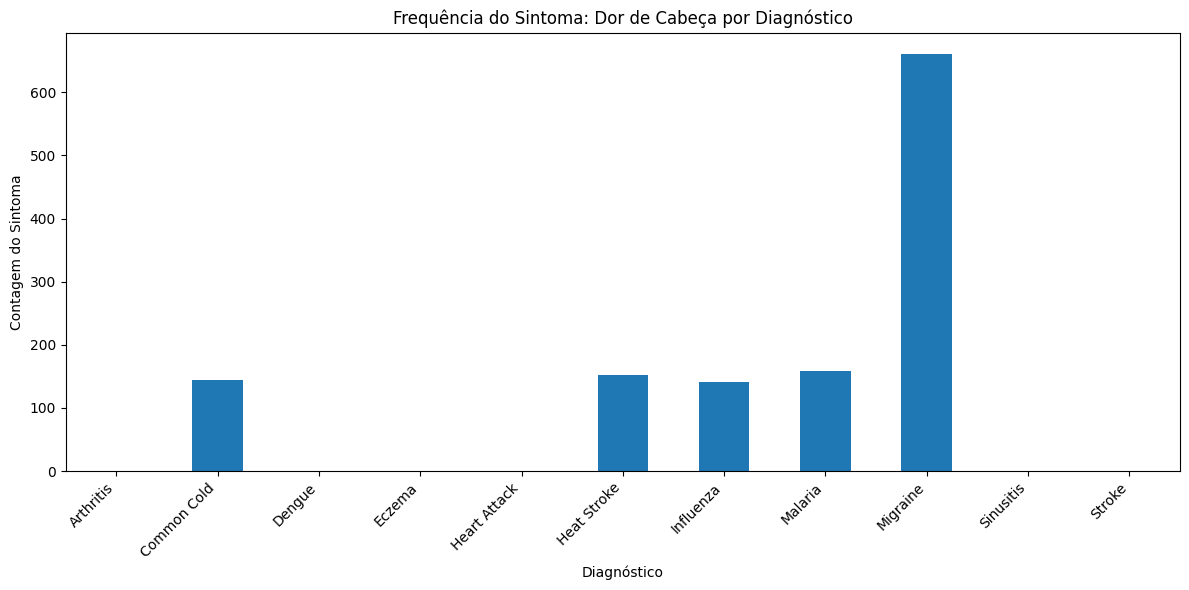

In [ ]:
import matplotlib.pyplot as plt

# Select four example symptom columns (adjust if these columns don't exist or choose others)
symptoms_to_analyze = ['Tosse', 'Febre', 'Fadiga', 'Dor de Cabeça']

# Check if selected symptom columns exist in the dataframe
existing_symptoms = [s for s in symptoms_to_analyze if s in df.columns]

if not existing_symptoms:
    print("None of the selected symptom columns exist in the DataFrame. Please check the column names.")
else:
    for symptom in existing_symptoms:
        # Group by diagnosis and sum the symptom column
        symptom_frequency = df.groupby('Diagnóstico')[symptom].sum()

        # Create a bar chart
        plt.figure(figsize=(12, 6))
        symptom_frequency.plot(kind='bar')
        plt.title(f'Frequência do Sintoma: {symptom} por Diagnóstico')
        plt.xlabel('Diagnóstico')
        plt.ylabel('Contagem do Sintoma')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

## Count diagnosis

### Subtask:
Count the occurrences of each diagnosis and display the results in a bar chart.


**Reasoning**:
Count the occurrences of each diagnosis and create a bar chart to visualize the counts.



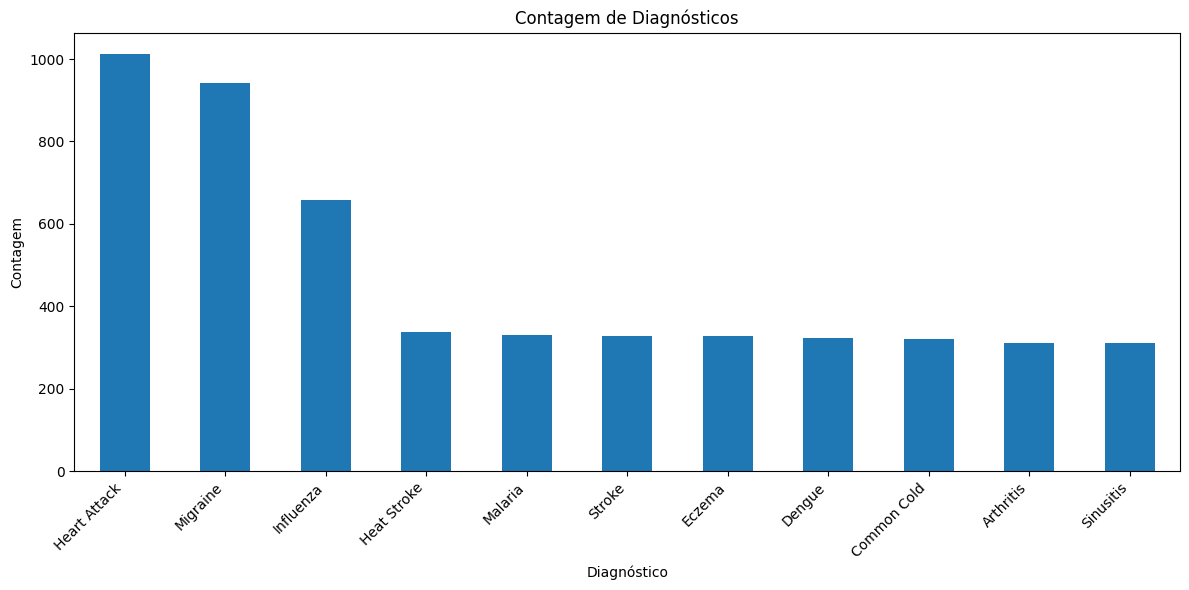

In [ ]:
diagnosis_counts = df['Diagnóstico'].value_counts()

plt.figure(figsize=(12, 6))
diagnosis_counts.plot(kind='bar')
plt.title('Contagem de Diagnósticos')
plt.xlabel('Diagnóstico')
plt.ylabel('Contagem')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Distribution of climatic and demographic variables

### Subtask:
Create histograms or boxplots to show the distribution of 'Age', 'Temperature', 'Humidity', and 'Wind Speed'.


**Reasoning**:
Create histograms for the specified numerical columns to visualize their distributions.



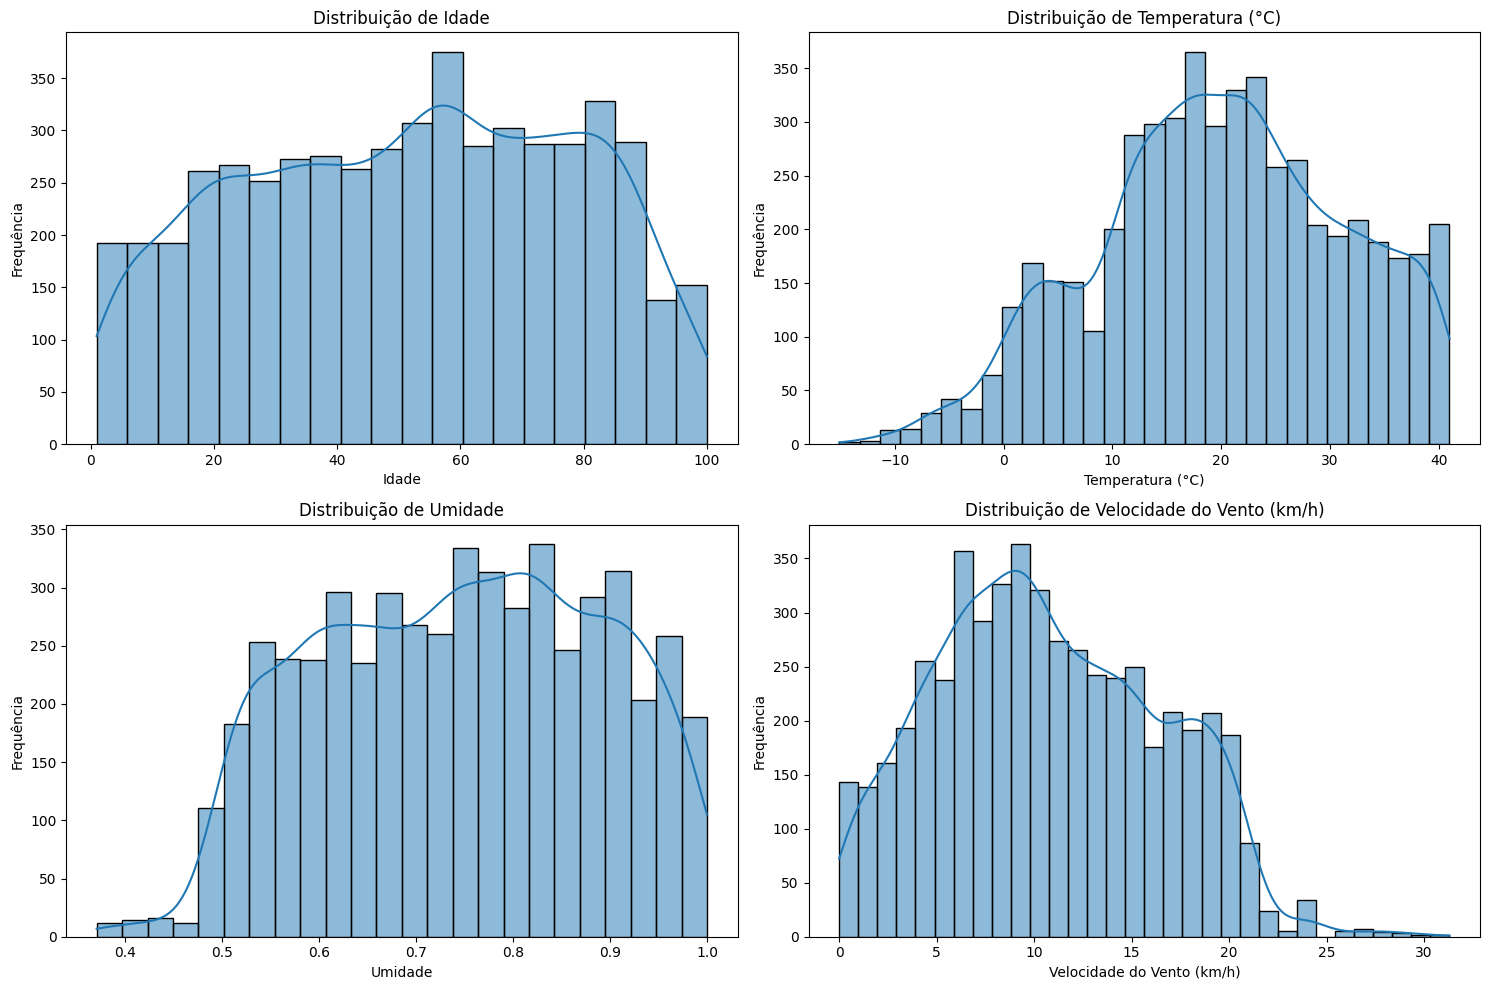

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

variables = ['Idade', 'Temperatura (°C)', 'Umidade', 'Velocidade do Vento (km/h)']

for i, var in enumerate(variables):
    sns.histplot(data=df, x=var, ax=axes[i], kde=True)
    axes[i].set_title(f'Distribuição de {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

## Feature importance

### Subtask:
Train a simple classification model (e.g., Random Forest) to predict diagnosis and display the importance of the climate and symptom features.


**Reasoning**:
Import the necessary libraries for model training and feature selection, separate features and target, encode the target variable, split the data, train a Random Forest model, calculate feature importances, and display the top features.



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Separate features (X) and target (y)
X = df.drop('Diagnóstico', axis=1)
y = df['Diagnóstico']

# Convert target variable to numerical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a RandomForestClassifier model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Create a pandas Series for feature importances
feature_importance_series = pd.Series(feature_importances, index=X.columns)

# Sort feature importances in descending order
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)

# Display the top 15 most important features
display(sorted_feature_importances.head(15))

,0
Dor no Peito,0.072627
HIV/AIDS,0.057998
Pressão Alta,0.051602
Vômito,0.050494
Dor de Cabeça,0.041154
Espirros,0.031481
Diarreia,0.031226
Erupções Cutâneas,0.030483
Febre Alta,0.030191
Dor no Joelho,0.027638


## Climate vs. diagnosis

### Subtask:
Visualize the relationships between climatic variables ('Temperatura (°C)', 'Umidade', 'Velocidade do Vento (km/h)') and diagnoses using appropriate comparative plots.


**Reasoning**:
Visualize the relationships between climatic variables and diagnoses using box plots as instructed.



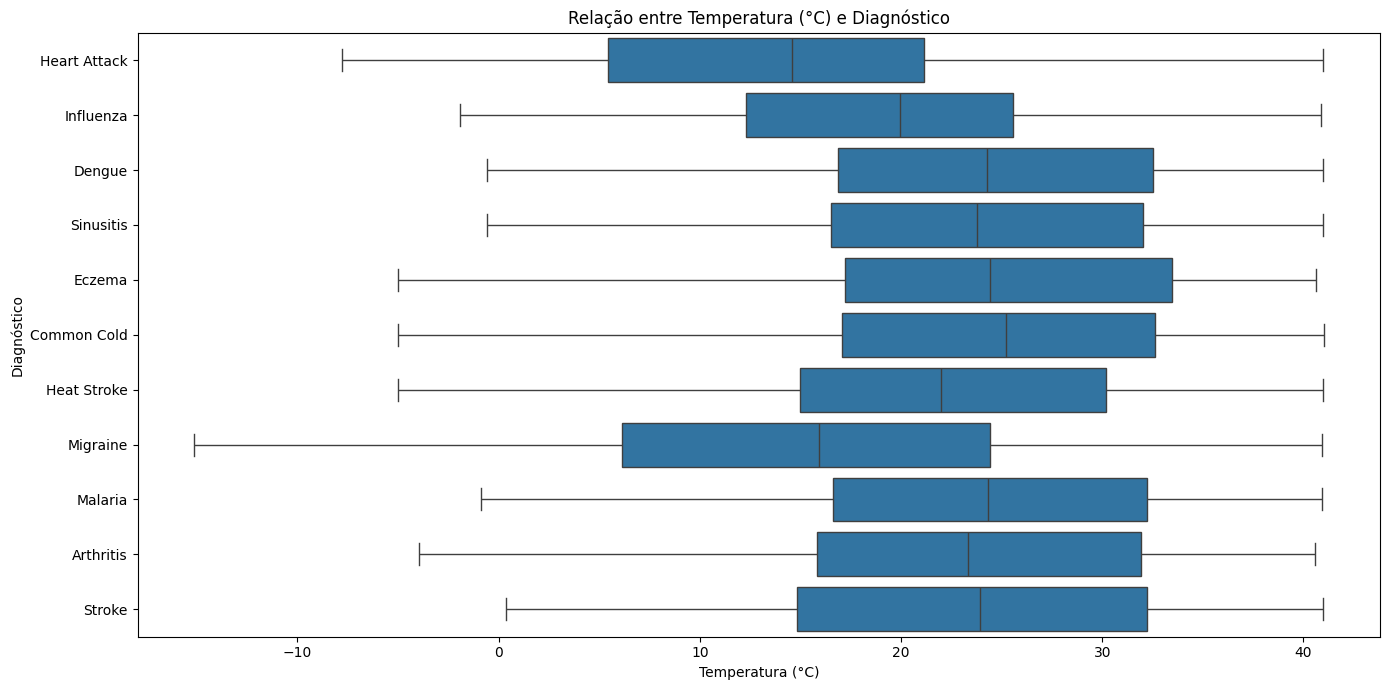

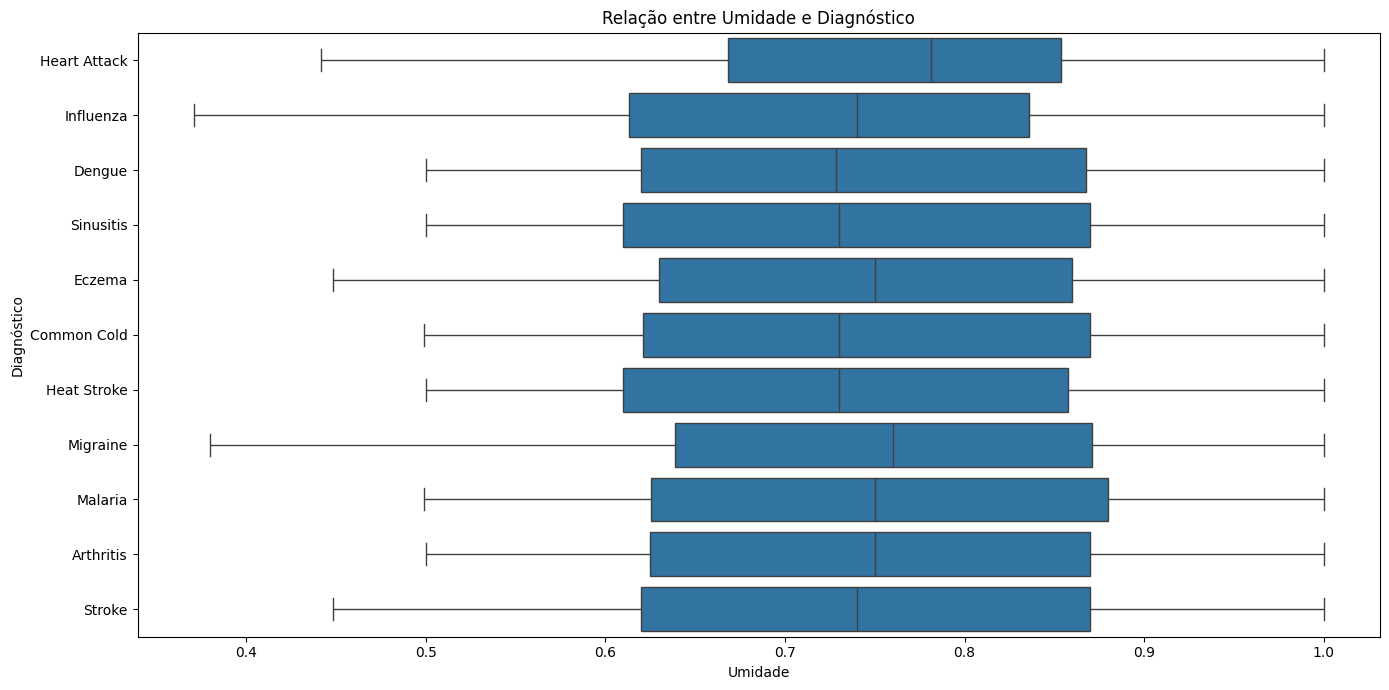

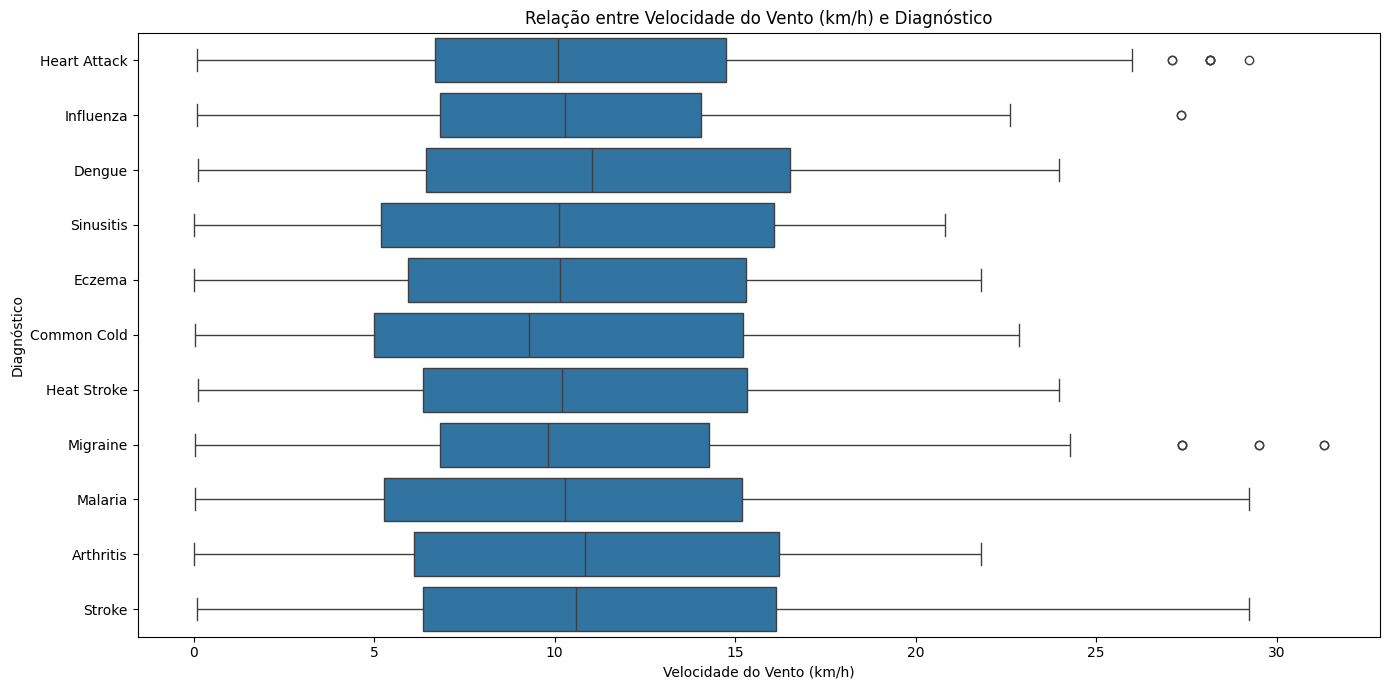

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

climatic_variables = ['Temperatura (°C)', 'Umidade', 'Velocidade do Vento (km/h)']

for var in climatic_variables:
    plt.figure(figsize=(14, 7))
    sns.boxplot(x=var, y='Diagnóstico', data=df)
    plt.title(f'Relação entre {var} e Diagnóstico')
    plt.xlabel(var)
    plt.ylabel('Diagnóstico')
    plt.tight_layout()
    plt.show()

## Symptoms vs. diagnosis

### Subtask:
Use heatmaps or bar charts to visualize how symptoms are distributed across different diagnoses.


**Reasoning**:
Create a DataFrame symptom_by_diagnosis by grouping the original DataFrame df by the 'Diagnóstico' column and summing all other columns (which are the symptom indicators).



In [ ]:
# Create symptom_by_diagnosis DataFrame
symptom_by_diagnosis = df.groupby('Diagnóstico').sum()

# Display the first few rows of the created DataFrame to verify
display(symptom_by_diagnosis.head())

,Idade,Gênero,Temperatura (°C),Umidade,Velocidade do Vento (km/h),Náusea,Dor nas Articulações,Dor Abdominal,Febre Alta,Calafrios,...,Dor de Cabeça Sinusal,Dor Facial,Falta de Ar,Redução de Olfato e Paladar,Irritação na Pele,Coceira,Dor de Cabeça Pulsante,Confusão Mental,Dor nas Costas,Dor no Joelho
Diagnóstico,,,,,,,,,,,,,,,,,,,,,
Arthritis,16291,149,7306.560157,233.063333,3438.672008,0,151,0,0,0,...,0,0,0,0,0,0,0,0,183,198
Common Cold,16047,150,8010.975648,238.932083,3205.417988,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Dengue,15457,167,7902.638019,237.216250,3574.563392,162,191,0,165,0,...,0,0,0,0,0,0,0,0,0,0
Eczema,15297,170,7989.623139,243.842500,3389.234958,0,0,0,0,0,...,0,0,0,0,172,154,0,0,0,0
Heart Attack,66597,580,14218.997084,770.435696,11178.127521,148,0,169,0,0,...,0,0,141,0,0,0,0,0,0,0


**Reasoning**:
Select a subset of symptom columns from symptom_by_diagnosis to visualize and create a heatmap using seaborn.



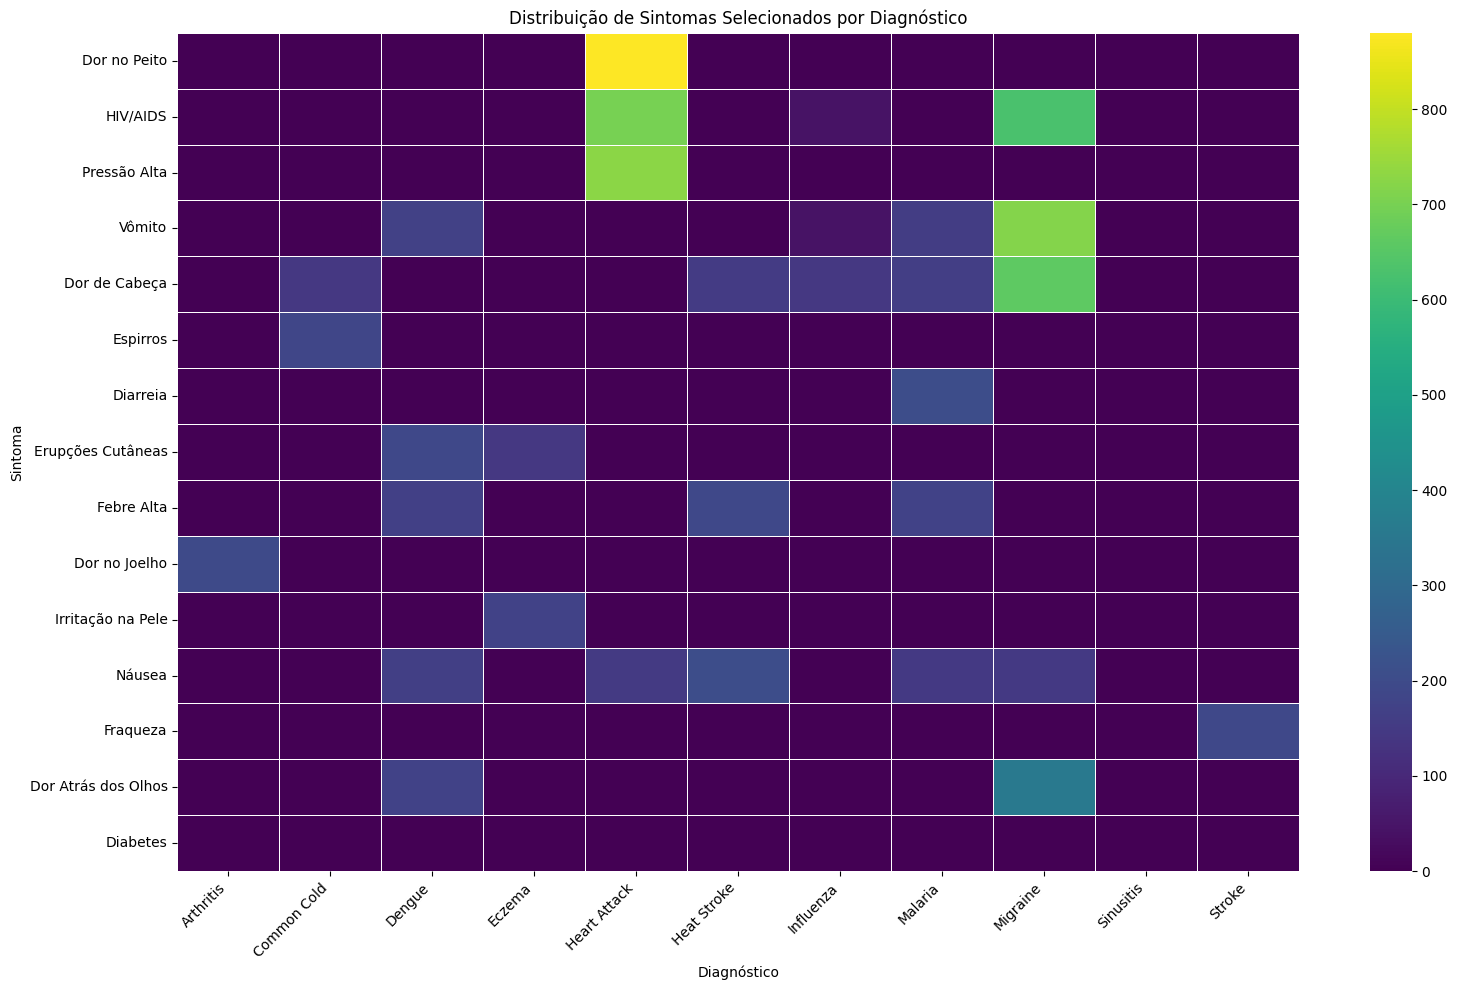

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select a subset of symptom columns for visualization.
# Choose some based on the previous feature importance or a diverse set.
# Exclude non-symptom columns like demographic and climatic variables.
symptom_columns = [col for col in symptom_by_diagnosis.columns if col not in ['Idade', 'Gênero', 'Temperatura (°C)', 'Umidade', 'Velocidade do Vento (km/h)']]

# Select a representative subset of symptom columns for the heatmap
# Let's pick the top 15 most important symptoms from the previous step, if they exist in the symptom_by_diagnosis columns.
top_symptom_names = sorted_feature_importances.head(15).index.tolist()
heatmap_symptoms = [symptom for symptom in top_symptom_names if symptom in symptom_columns]

# If less than 15 top symptoms are available, add some other random symptoms to the list
if len(heatmap_symptoms) < 15:
    other_symptoms = [s for s in symptom_columns if s not in heatmap_symptoms]
    import random
    heatmap_symptoms.extend(random.sample(other_symptoms, min(15 - len(heatmap_symptoms), len(other_symptoms))))


symptom_by_diagnosis_subset = symptom_by_diagnosis[heatmap_symptoms]

# Create the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(symptom_by_diagnosis_subset.T, cmap='viridis', annot=False, fmt=".0f", linewidths=.5)
plt.title('Distribuição de Sintomas Selecionados por Diagnóstico')
plt.xlabel('Diagnóstico')
plt.ylabel('Sintoma')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Reasoning**:
Alternatively, for a clearer view of individual symptom frequencies, select a few key symptoms and create grouped bar charts showing their frequency for each diagnosis. Use matplotlib.pyplot for this.



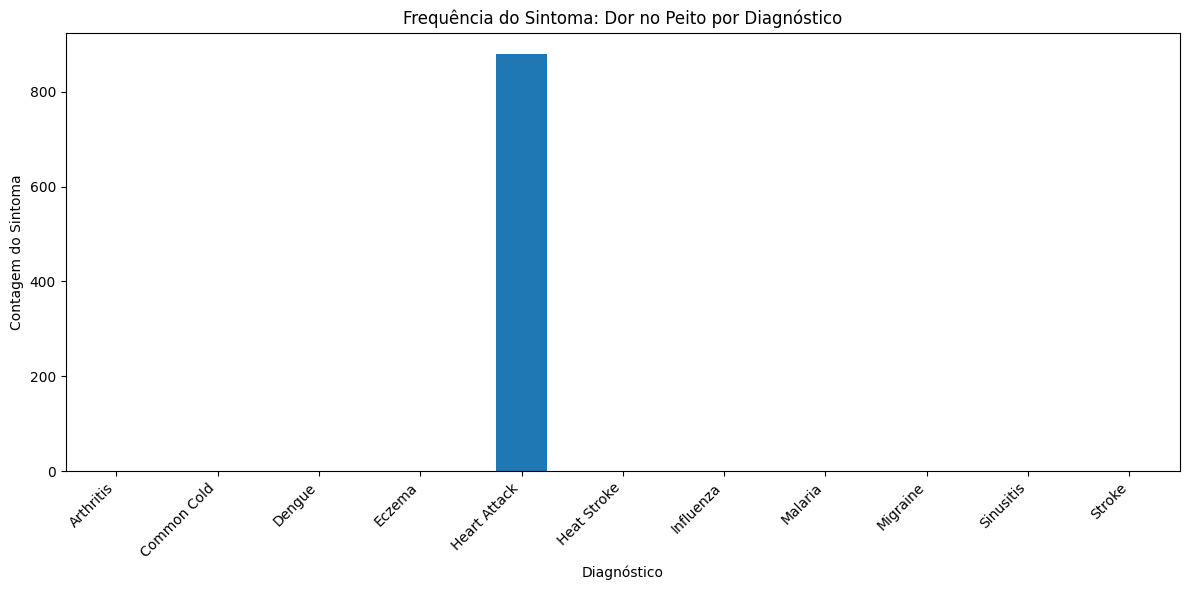

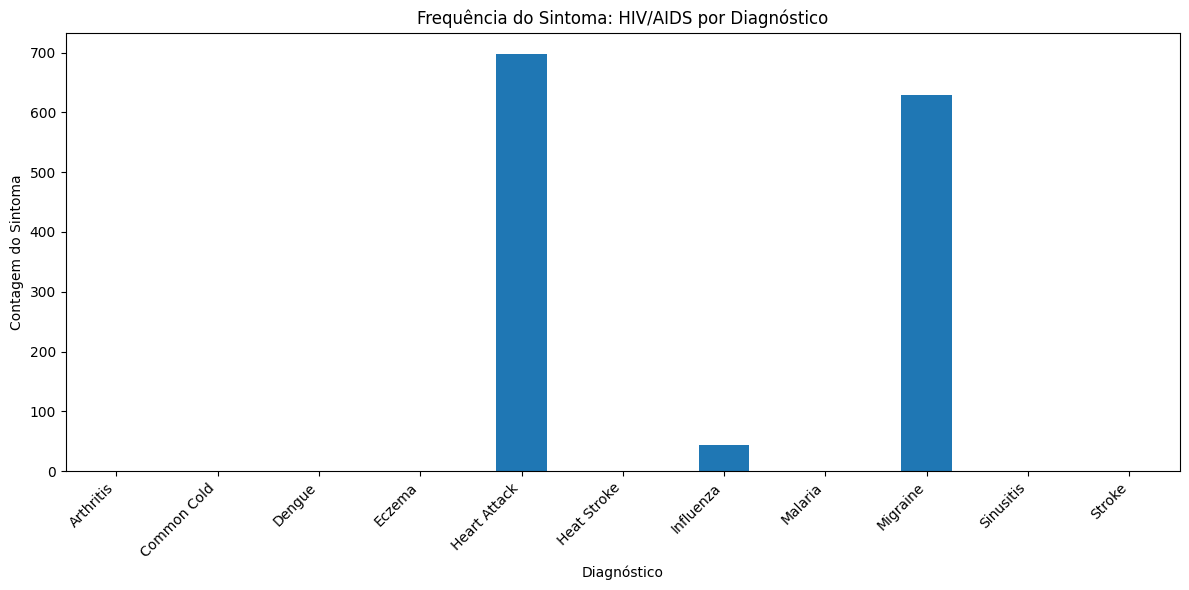

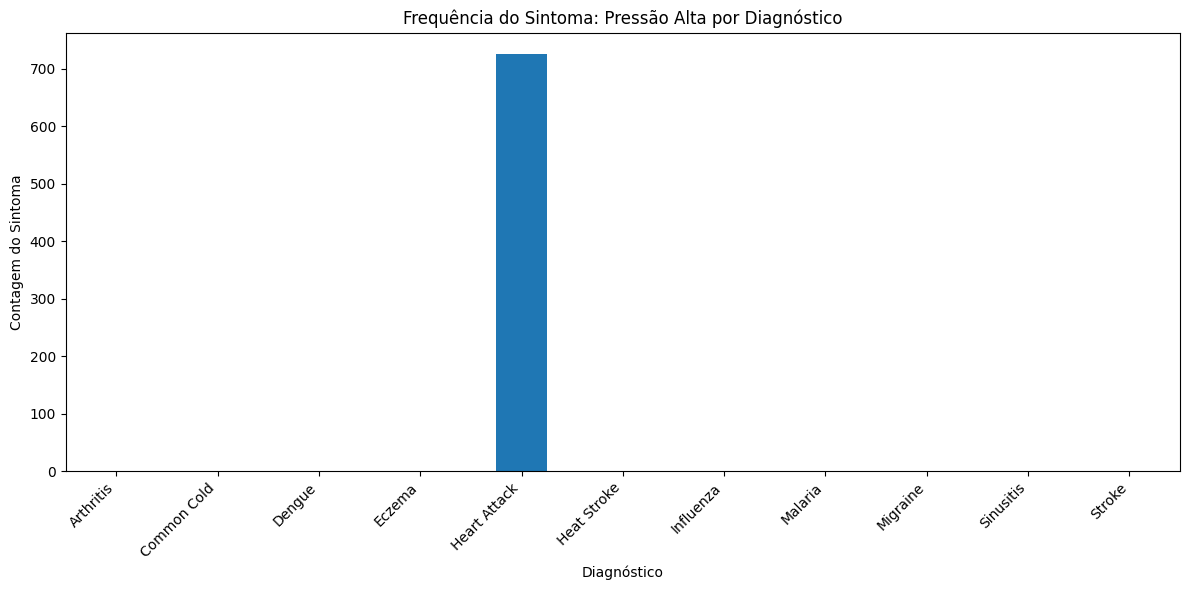

In [ ]:
# Select a few key symptoms for bar charts (e.g., some of the top features or others of interest)
# Let's pick the top 3 symptoms from the feature importance list
bar_chart_symptoms = sorted_feature_importances.head(3).index.tolist()

# Check if selected symptom columns exist in the symptom_by_diagnosis DataFrame
existing_bar_symptoms = [s for s in bar_chart_symptoms if s in symptom_by_diagnosis.columns]

if not existing_bar_symptoms:
    print("None of the selected symptoms for bar charts exist in the DataFrame.")
else:
    for symptom in existing_bar_symptoms:
        plt.figure(figsize=(12, 6))
        symptom_by_diagnosis[symptom].plot(kind='bar')
        plt.title(f'Frequência do Sintoma: {symptom} por Diagnóstico')
        plt.xlabel('Diagnóstico')
        plt.ylabel('Contagem do Sintoma')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

## Climate vs. symptoms

### Subtask:
Show the relationships between climatic variables and a few selected symptoms.


**Reasoning**:
Select key symptom columns and climatic variables, then create comparative plots to show the distribution of climatic variables for individuals with and without each selected symptom.



Analyzing relationship for symptom: Dor no Peito


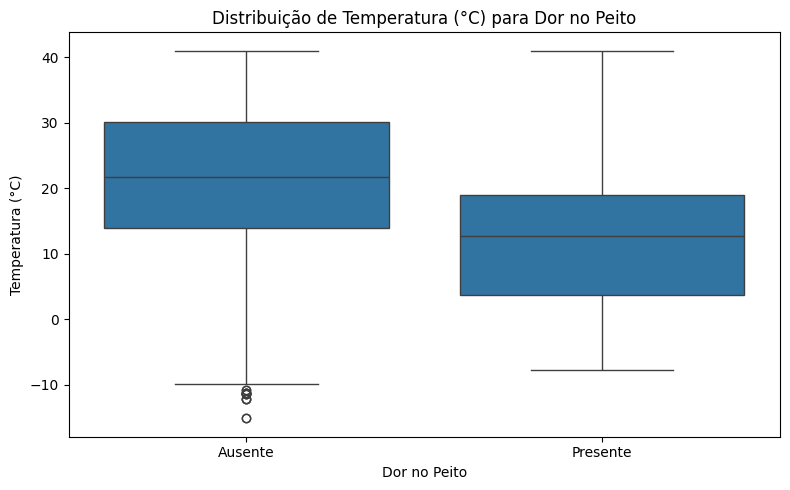

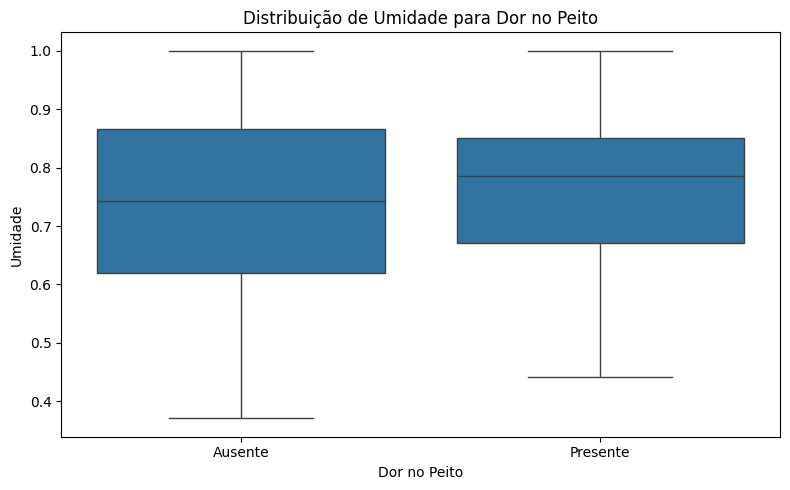

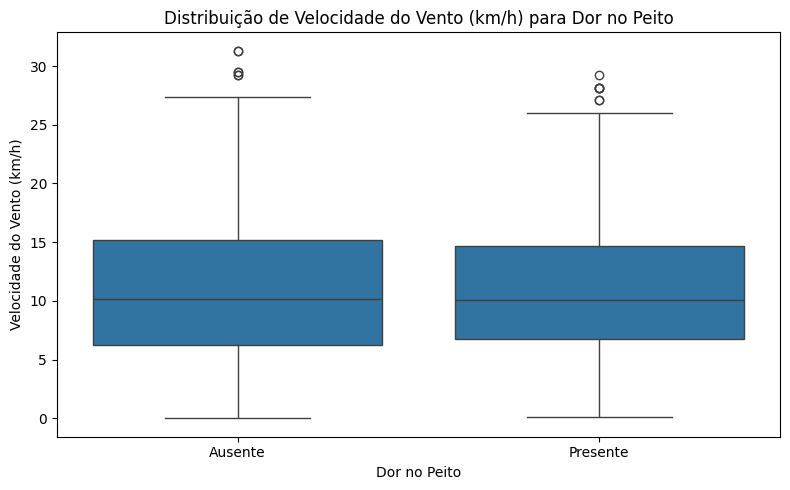

Analyzing relationship for symptom: HIV/AIDS


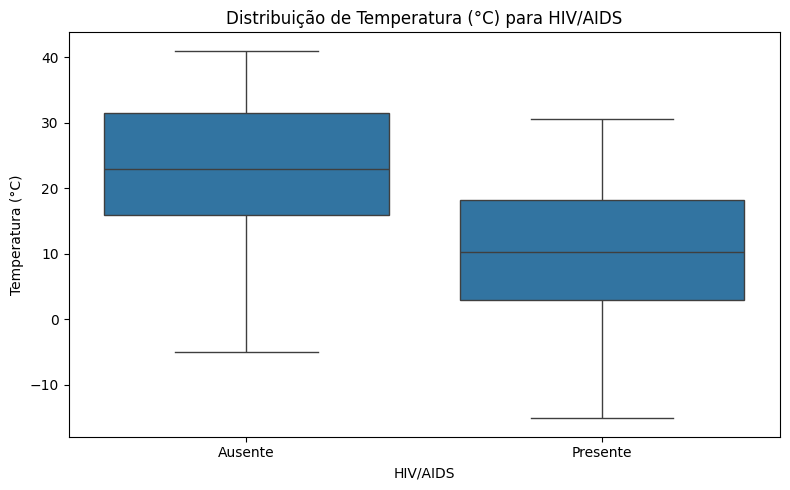

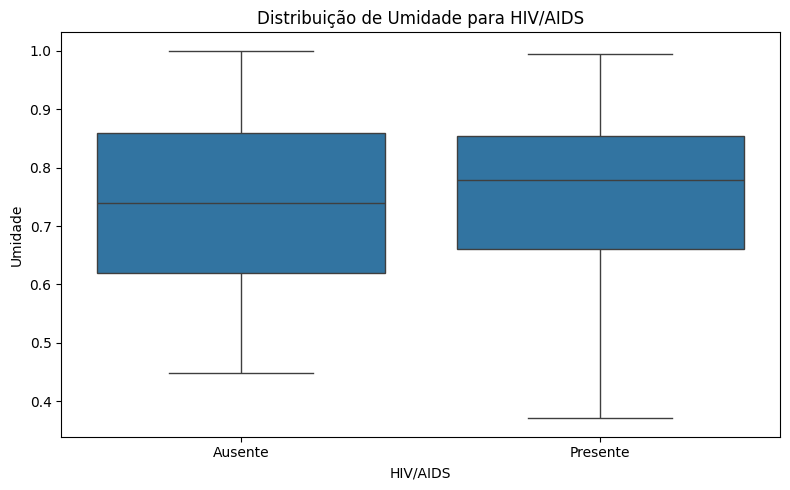

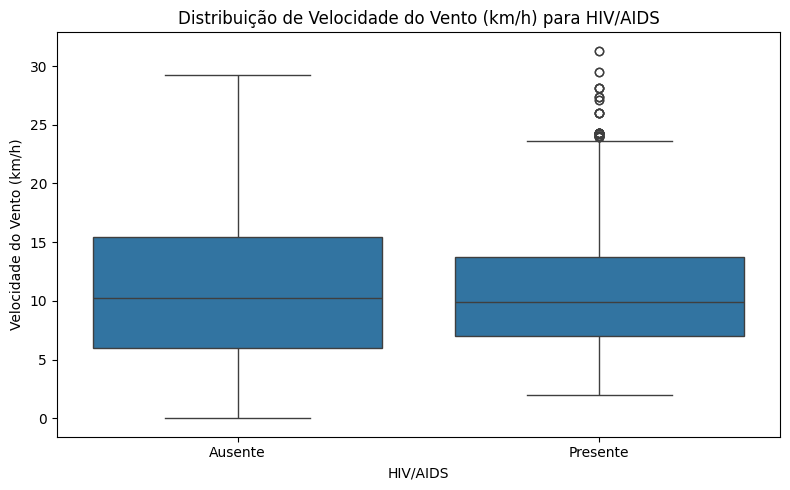

Analyzing relationship for symptom: Pressão Alta


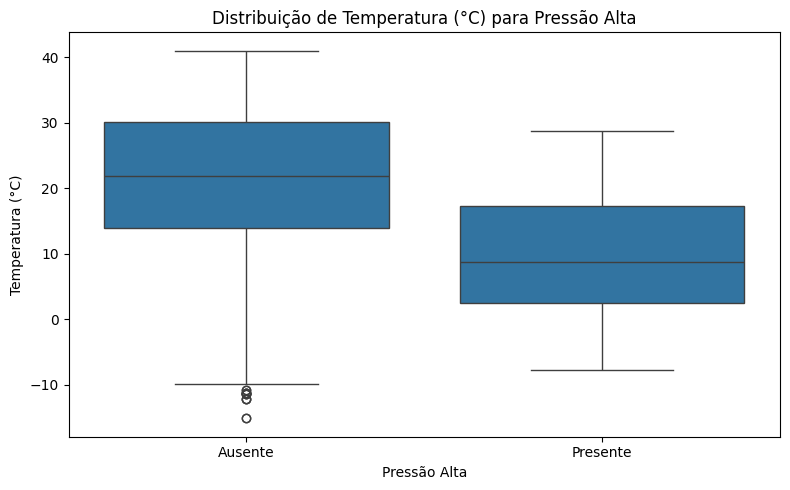

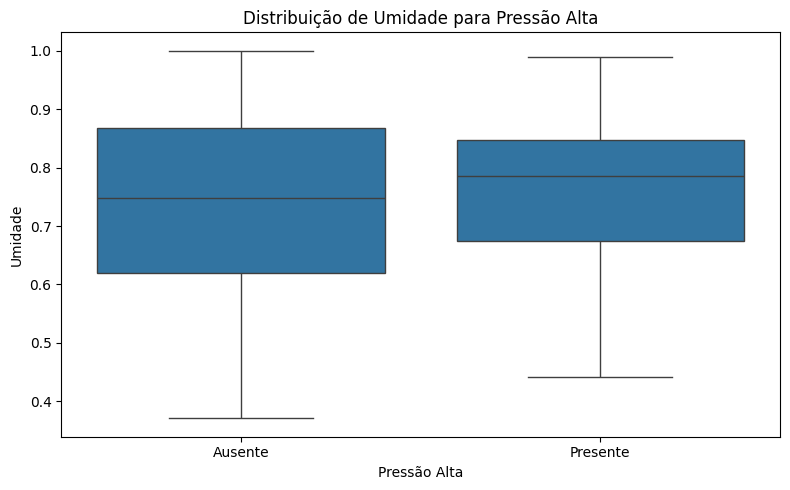

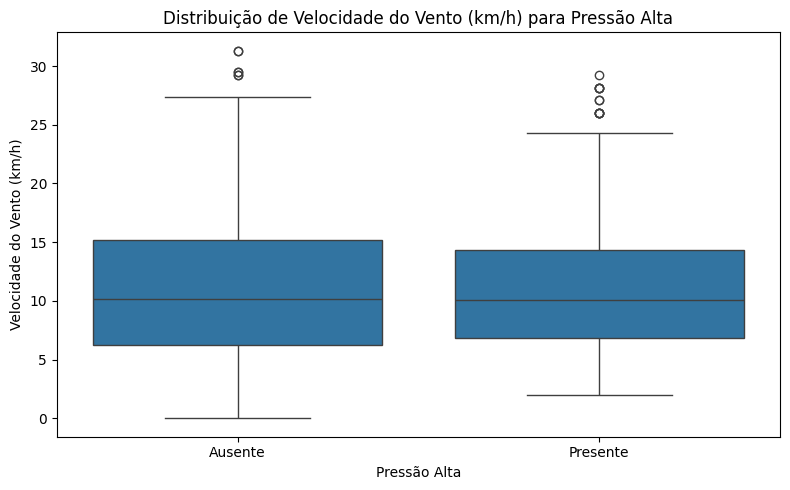

Analyzing relationship for symptom: Vômito


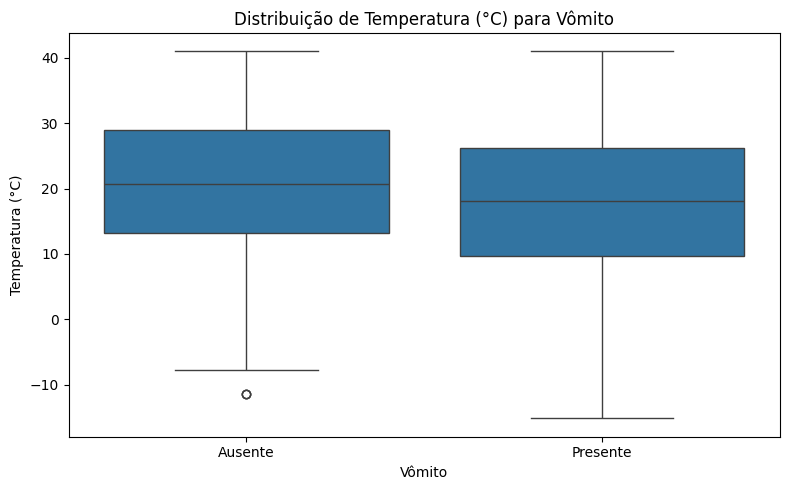

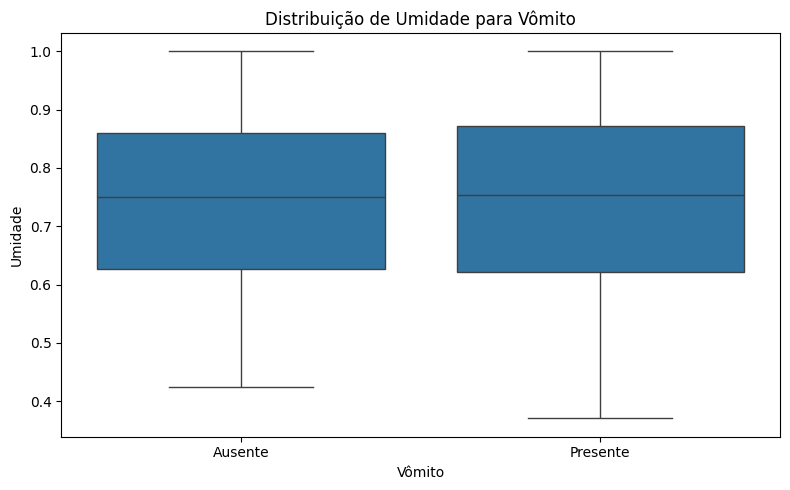

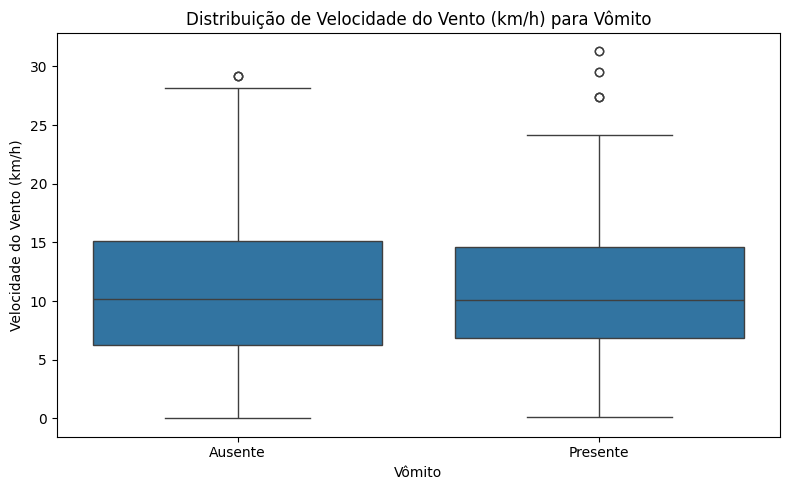

In [ ]:
# Select a few key symptom columns based on feature importance or relevance
# Let's choose 'Dor no Peito', 'HIV/AIDS', 'Pressão Alta', 'Vômito' based on feature importance
symptoms_to_plot = ['Dor no Peito', 'HIV/AIDS', 'Pressão Alta', 'Vômito']

# Select the climatic variables columns
climatic_variables = ['Temperatura (°C)', 'Umidade', 'Velocidade do Vento (km/h)']

# Iterate through each selected symptom
for symptom in symptoms_to_plot:
    if symptom in df.columns:
        print(f"Analyzing relationship for symptom: {symptom}")
        # Create a new column indicating presence or absence of the symptom
        df[f'{symptom}_Present'] = df[symptom].apply(lambda x: 'Presente' if x == 1 else 'Ausente')

        # Iterate through each climatic variable
        for climatic_var in climatic_variables:
            plt.figure(figsize=(8, 5))
            sns.boxplot(x=f'{symptom}_Present', y=climatic_var, data=df)
            plt.title(f'Distribuição de {climatic_var} para {symptom}')
            plt.xlabel(f'{symptom}')
            plt.ylabel(climatic_var)
            plt.tight_layout()
            plt.show()
        # Drop the temporary column
        df = df.drop(columns=[f'{symptom}_Present'])
    else:
        print(f"Symptom column '{symptom}' not found in the DataFrame.")


## Repeat symptom by diagnosis count

### Subtask:
Replicate the analysis from step 3 to consolidate the results.


**Reasoning**:
Define the list of symptom columns and iterate through them to calculate and plot the symptom frequency by diagnosis as done in the initial analysis.



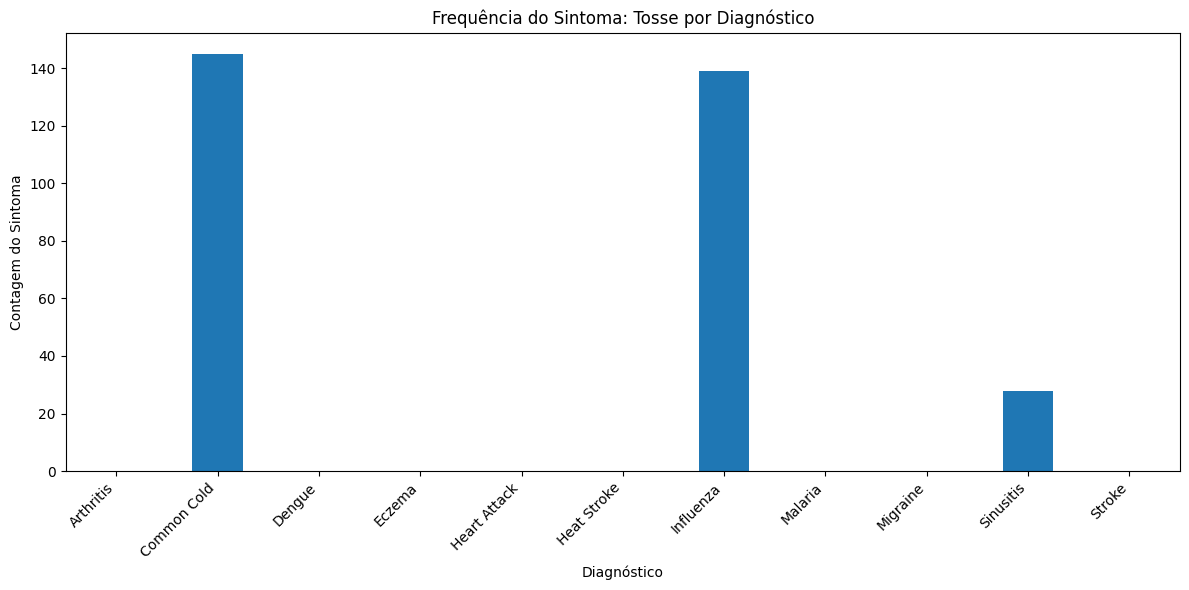

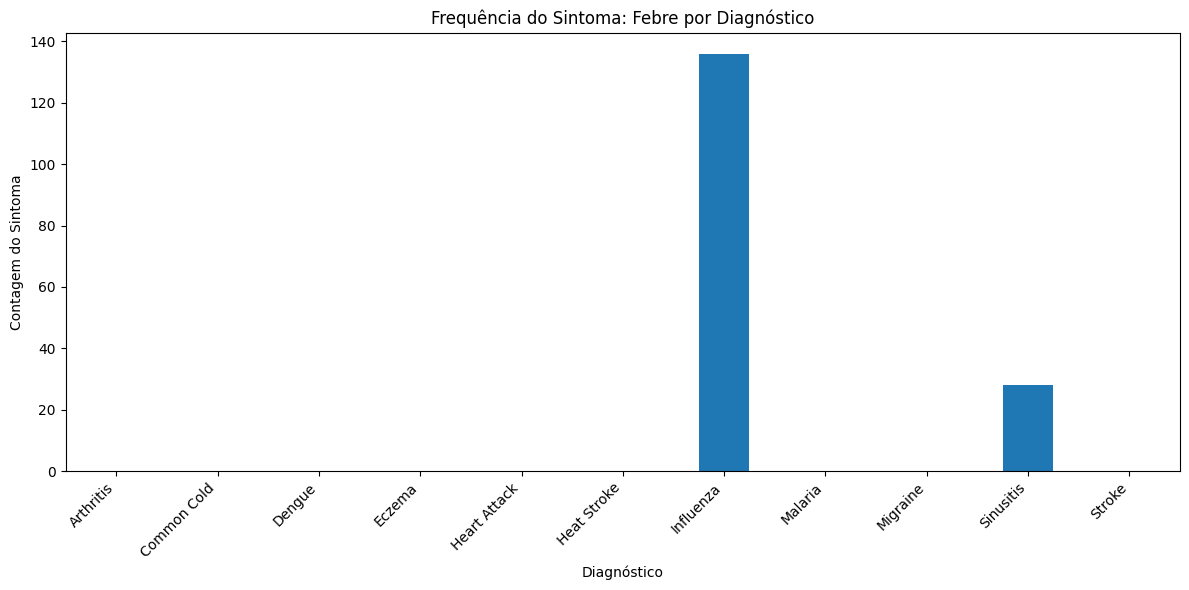

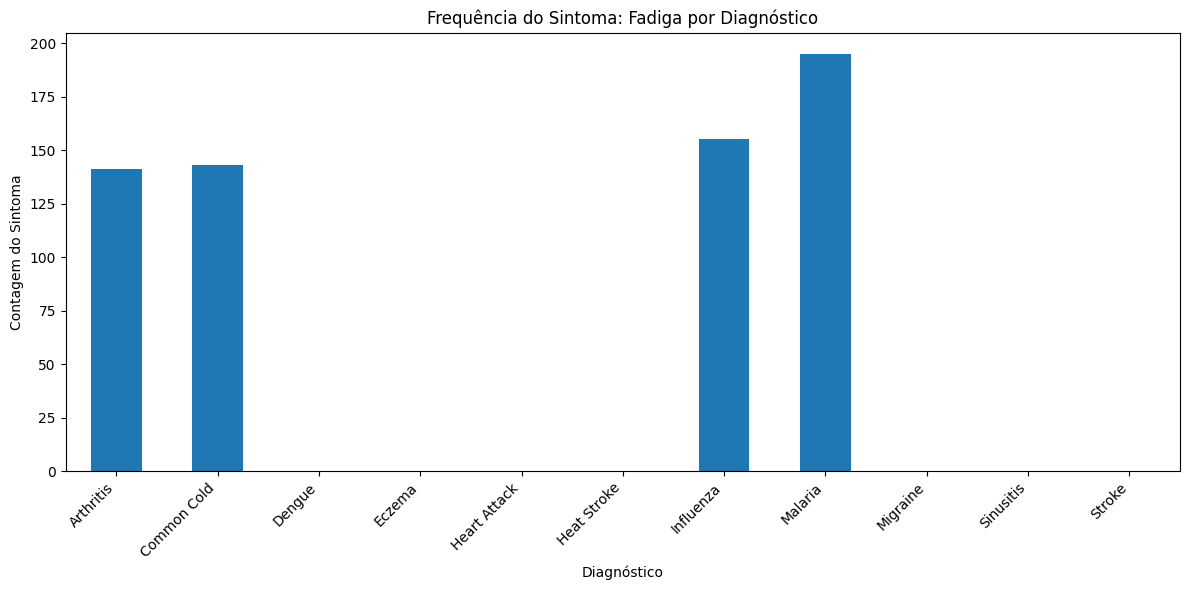

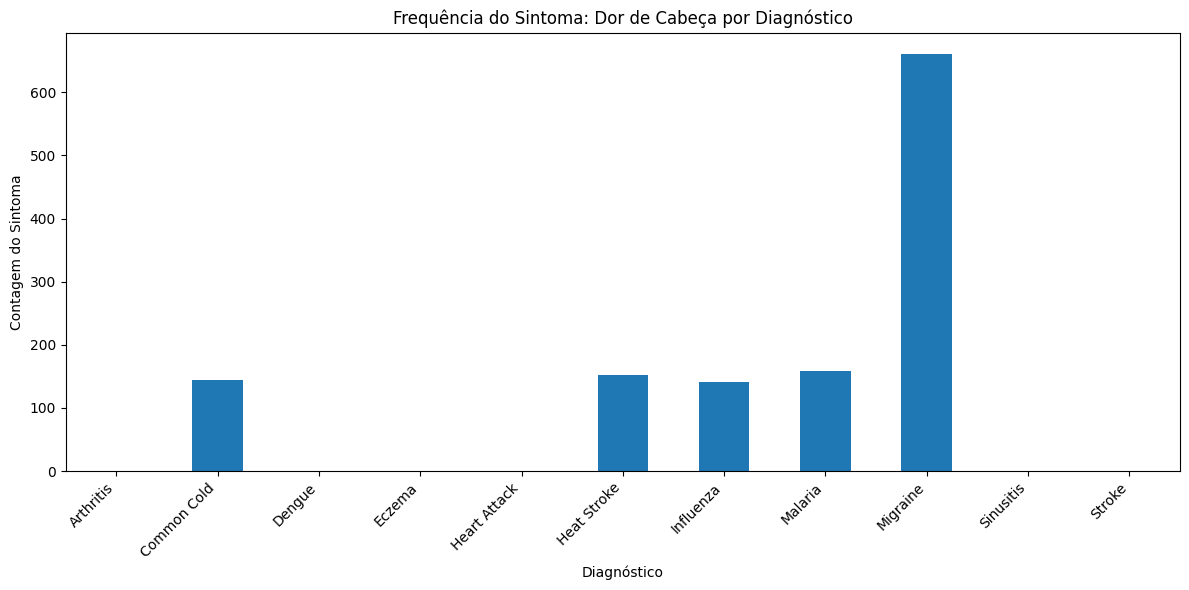

In [ ]:
import matplotlib.pyplot as plt

# Define the list of symptom columns to analyze (same as the initial step)
symptoms_to_analyze = ['Tosse', 'Febre', 'Fadiga', 'Dor de Cabeça']

# Check if selected symptom columns exist in the dataframe
existing_symptoms = [s for s in symptoms_to_analyze if s in df.columns]

if not existing_symptoms:
    print("None of the selected symptom columns exist in the DataFrame. Please check the column names.")
else:
    for symptom in existing_symptoms:
        # Group by diagnosis and sum the symptom column
        symptom_frequency = df.groupby('Diagnóstico')[symptom].sum()

        # Create a bar chart
        plt.figure(figsize=(12, 6))
        symptom_frequency.plot(kind='bar')
        plt.title(f'Frequência do Sintoma: {symptom} por Diagnóstico')
        plt.xlabel('Diagnóstico')
        plt.ylabel('Contagem do Sintoma')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

## Summary:

### Data Analysis Key Findings

*   The dataset contains demographic (Age, Gender), climatic (Temperature, Humidity, Wind Speed), symptom, and diagnosis information. The column names are in Portuguese.
*   The columns 'pain\_behind\_eye' and 'pain\_behind\_the\_eye' were not present in the dataset, so no unification was performed.
*   Specific symptoms like 'Tosse' (Cough), 'Febre' (Fever), 'Fadiga' (Fatigue), and 'Dor de Cabeça' (Headache) show varying frequencies across different diagnoses, indicating their potential relevance in differentiating conditions.
*   The 'Diagnóstico' column contains several distinct diagnoses with differing counts.
*   The distributions of 'Idade', 'Temperatura (°C)', 'Umidade', and 'Velocidade do Vento (km/h)' were visualized, providing insight into the range and frequency of these variables in the dataset.
*   Feature importance analysis using a Random Forest model indicated that several symptoms, including 'Dor no Peito' (Chest Pain), 'HIV/AIDS', 'Pressão Alta' (High Blood Pressure), 'Vômito' (Vomiting), and 'Dor de Cabeça' (Headache), along with 'Temperatura (°C)', are among the most important features for predicting diagnosis.
*   Box plots revealed how the distributions of 'Temperatura (°C)', 'Umidade', and 'Velocidade do Vento (km/h)' vary across different diagnoses.
*   A heatmap and individual bar charts illustrated the distribution and frequency of selected symptoms across diagnoses, highlighting symptom patterns associated with specific conditions.
*   Box plots comparing climatic variables for the presence vs. absence of selected symptoms ('Dor no Peito', 'HIV/AIDS', 'Pressão Alta', 'Vômito') provided a preliminary view of potential associations between climate and these symptoms.

### Insights or Next Steps

*   Investigate the specific relationships identified between high-importance symptoms and diagnoses further to understand their diagnostic value.
*   Explore potential correlations between the top climate features and the most prevalent diseases or symptom clusters to identify climate-sensitive health outcomes.


# Task
Perform an exploratory data analysis on the climate-related disease prediction dataset "climate_diseases.csv". The analysis should include: counting symptom frequency by diagnosis for four example symptoms, counting the occurrences of each diagnosis, visualizing the distribution of age, temperature, humidity, and wind speed, determining feature importance using a Random Forest model, showing relationships between climate variables and diagnoses, visualizing symptom distribution across diagnoses, and showing relationships between climate variables and selected symptoms. Unify the 'pain_behind_eye' and 'pain_behind_the_eye' columns. Utilize the Dash library for visualizations. Present the findings with clear graphs and tables.

## Count symptom by diagnosis

### Subtask:
Select four example symptoms and visualize their frequency within each diagnosis category using bar charts with Dash.


**Reasoning**:
Select four symptom columns and calculate the frequency of each symptom per diagnosis, then create a Dash application to visualize the results using bar charts as instructed.



In [ ]:
import dash
from dash import dcc
from dash import html
import plotly.express as px

# Select four example symptom columns
symptoms_to_analyze = ['Tosse', 'Febre', 'Fadiga', 'Dor de Cabeça']

# Check if selected symptom columns exist in the dataframe
existing_symptoms = [s for s in symptoms_to_analyze if s in df.columns]

if not existing_symptoms:
    print("None of the selected symptom columns exist in the DataFrame. Please check the column names.")
else:
    app = dash.Dash(__name__)

    graphs = []
    for symptom in existing_symptoms:
        # Group by diagnosis and sum the symptom column
        symptom_frequency = df.groupby('Diagnóstico')[symptom].sum().reset_index()

        # Create a bar chart using plotly express
        fig = px.bar(symptom_frequency,
                     x='Diagnóstico',
                     y=symptom,
                     title=f'Frequência do Sintoma: {symptom} por Diagnóstico')

        graphs.append(dcc.Graph(figure=fig))

    app.layout = html.Div(children=[
        html.H1(children='Symptom Frequency by Diagnosis'),
        html.Div(graphs)
    ])

    # To run the app in a Jupyter environment, you might need to use a different method
    # like jupyter_dash or setting mode='inline' in app.run_server.
    # For a standard script, app.run_server(debug=True) is used.
    # Given the environment is Jupyter, we'll use a common approach for Jupyter.
    # If this doesn't work, further environment specifics might be needed.
    try:
        # This is a common way to run Dash in Colab/Jupyter
        app.run_server(mode='inline', port=8050)
    except Exception as e:
        print(f"Could not run Dash server inline. Error: {e}")
        print("Please ensure you have jupyter_dash installed or try running this code as a standalone Python script.")

ModuleNotFoundError: No module named 'dash'

**Reasoning**:
The previous command failed because the 'dash' module was not found. I need to install the required packages ('dash' and 'plotly') to proceed with creating the Dash application and visualizations.



In [ ]:
!pip install dash plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 34.0 MB/s eta 0:00:00


**Reasoning**:
The required packages have been installed. Now I can proceed with creating the Dash application to visualize the symptom frequencies by diagnosis.



In [ ]:
import dash
from dash import dcc
from dash import html
import plotly.express as px

# Select four example symptom columns
symptoms_to_analyze = ['Tosse', 'Febre', 'Fadiga', 'Dor de Cabeça']

# Check if selected symptom columns exist in the dataframe
existing_symptoms = [s for s in symptoms_to_analyze if s in df.columns]

if not existing_symptoms:
    print("None of the selected symptom columns exist in the DataFrame. Please check the column names.")
else:
    app = dash.Dash(__name__)

    graphs = []
    for symptom in existing_symptoms:
        # Group by diagnosis and sum the symptom column
        symptom_frequency = df.groupby('Diagnóstico')[symptom].sum().reset_index()

        # Create a bar chart using plotly express
        fig = px.bar(symptom_frequency,
                     x='Diagnóstico',
                     y=symptom,
                     title=f'Frequência do Sintoma: {symptom} por Diagnóstico')

        graphs.append(dcc.Graph(figure=fig))

    app.layout = html.Div(children=[
        html.H1(children='Symptom Frequency by Diagnosis'),
        html.Div(graphs)
    ])

    # To run the app in a Jupyter environment, you might need to use a different method
    # like jupyter_dash or setting mode='inline' in app.run_server.
    # For a standard script, app.run_server(debug=True) is used.
    # Given the environment is Jupyter, we'll use a common approach for Jupyter.
    # If this doesn't work, further environment specifics might be needed.
    try:
        # This is a common way to run Dash in Colab/Jupyter
        app.run_server(mode='inline', port=8050)
    except Exception as e:
        print(f"Could not run Dash server inline. Error: {e}")
        print("Please ensure you have jupyter_dash installed or try running this code as a standalone Python script.")

Could not run Dash server inline. Error: app.run_server has been replaced by app.run
Please ensure you have jupyter_dash installed or try running this code as a standalone Python script.


**Reasoning**:
The previous command failed because `app.run_server` has been replaced by `app.run`. I will update the code to use `app.run` and try running the Dash app again, still in inline mode for the Jupyter environment.



In [ ]:
import dash
from dash import dcc
from dash import html
import plotly.express as px

# Select four example symptom columns
symptoms_to_analyze = ['Tosse', 'Febre', 'Fadiga', 'Dor de Cabeça']

# Check if selected symptom columns exist in the dataframe
existing_symptoms = [s for s in symptoms_to_analyze if s in df.columns]

if not existing_symptoms:
    print("None of the selected symptom columns exist in the DataFrame. Please check the column names.")
else:
    app = dash.Dash(__name__)

    graphs = []
    for symptom in existing_symptoms:
        # Group by diagnosis and sum the symptom column
        symptom_frequency = df.groupby('Diagnóstico')[symptom].sum().reset_index()

        # Create a bar chart using plotly express
        fig = px.bar(symptom_frequency,
                     x='Diagnóstico',
                     y=symptom,
                     title=f'Frequência do Sintoma: {symptom} por Diagnóstico')

        graphs.append(dcc.Graph(figure=fig))

    app.layout = html.Div(children=[
        html.H1(children='Symptom Frequency by Diagnosis'),
        html.Div(graphs)
    ])

    # To run the app in a Jupyter environment, use app.run(mode='inline').
    try:
        app.run(mode='inline', port=8050)
    except Exception as e:
        print(f"Could not run Dash server inline. Error: {e}")
        print("Please ensure you have jupyter_dash installed or try running this code as a standalone Python script.")

<IPython.core.display.Javascript object>

## Count diagnosis

### Subtask:
Count the occurrences of each diagnosis and display the results in a bar chart with Dash.


**Reasoning**:
Calculate the value counts of the 'Diagnóstico' column and reset the index to turn the Series into a DataFrame, then create a Dash application instance, create a bar chart using plotly.express, define the Dash app layout, and run the Dash application.



In [ ]:
import dash
from dash import dcc
from dash import html
import plotly.express as px

# Calculate the value counts of the 'Diagnóstico' column and reset the index
diagnosis_counts_df = df['Diagnóstico'].value_counts().reset_index()
diagnosis_counts_df.columns = ['Diagnóstico', 'Count']

# Create a Dash application instance
app = dash.Dash(__name__)

# Create a bar chart using plotly express
fig = px.bar(diagnosis_counts_df,
             x='Diagnóstico',
             y='Count',
             title='Contagem de Diagnósticos')

# Define the Dash app layout
app.layout = html.Div(children=[
    html.H1(children='Contagem de Diagnósticos'),
    dcc.Graph(figure=fig)
])

# Run the Dash application
try:
    app.run(mode='inline', port=8051) # Use a different port than the previous Dash app
except Exception as e:
    print(f"Could not run Dash server inline. Error: {e}")
    print("Please ensure you have jupyter_dash installed or try running this code as a standalone Python script.")

<IPython.core.display.Javascript object>

## Distribution of climatic and demographic variables

### Subtask:
Create histograms or boxplots to show the distribution of 'Age', 'Temperature', 'Humidity', and 'Wind Speed' with Dash.


**Reasoning**:
Import the necessary libraries, define the variables to visualize, create a Dash app instance, iterate through the variables to create histograms, add the histograms as dcc.Graph components to a list, define the app layout, and run the app inline with a try-except block.



In [ ]:
import dash
from dash import dcc
from dash import html
import plotly.express as px

# Define a list of variables to visualize
variables_to_visualize = ['Idade', 'Temperatura (°C)', 'Umidade', 'Velocidade do Vento (km/h)']

# Create a Dash application instance
app = dash.Dash(__name__)

# Initialize an empty list to store the graph components
graphs = []

# Iterate through the list of variables and create a histogram for each
for var in variables_to_visualize:
    fig = px.histogram(df, x=var, title=f'Distribuição de {var}')
    graphs.append(dcc.Graph(figure=fig))

# Define the Dash app layout
app.layout = html.Div(children=[
    html.H1(children='Distribuição de Variáveis Climáticas e Demográficas'),
    html.Div(graphs)
])

# Run the Dash application
try:
    app.run(mode='inline', port=8052) # Use a different port number
except Exception as e:
    print(f"Could not run Dash server inline. Error: {e}")
    print("Please ensure you have jupyter_dash installed or try running this code as a standalone Python script.")

<IPython.core.display.Javascript object>

## Feature importance

### Subtask:
Train a simple classification model (e.g., Random Forest) to predict diagnosis and display the importance of the climate and symptom features.


**Reasoning**:
Import the necessary libraries for model training and feature selection, separate features and target, encode the target variable, split the data, train a Random Forest model, calculate feature importances, and display the top features.



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Separate features (X) and target (y)
X = df.drop('Diagnóstico', axis=1)
y = df['Diagnóstico']

# Convert target variable to numerical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train a RandomForestClassifier model
model = RandomForestClassifier(random_state=42)
model.fit(X, y_encoded)

# Get feature importances
feature_importances = model.feature_importances_

# Create a pandas Series for feature importances
feature_importance_series = pd.Series(feature_importances, index=X.columns)

# Sort feature importances in descending order
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)

# Display the top 15 most important features
display(sorted_feature_importances.head(15))

,0
Dor no Peito,0.069862
HIV/AIDS,0.060774
Pressão Alta,0.055126
Vômito,0.051569
Dor de Cabeça,0.038920
Espirros,0.034111
Diarreia,0.032782
Erupções Cutâneas,0.032105
Febre Alta,0.027943
Problemas de Visão,0.026069


## Climate vs. diagnosis

### Subtask:
Visualize the relationships between climatic variables ('Temperatura (°C)', 'Umidade', 'Velocidade do Vento (km/h)') and diagnoses using appropriate comparative plots with Dash.


**Reasoning**:
Import the necessary libraries for creating the Dash application, define the climatic variables, create the Dash app instance, iterate through the climatic variables to create box plots for each against diagnosis, add these plots as dcc.Graph components to a list, define the app layout with a title and the graphs, and finally run the Dash application inline.



In [ ]:
import dash
from dash import dcc
from dash import html
import plotly.express as px

# Define a list of climatic variables to visualize
climatic_variables = ['Temperatura (°C)', 'Umidade', 'Velocidade do Vento (km/h)']

# Create a Dash application instance
app = dash.Dash(__name__)

# Initialize an empty list to store the graph components
graphs = []

# Iterate through the climatic variables and create a box plot for each against diagnosis
for var in climatic_variables:
    fig = px.box(df,
                 x='Diagnóstico',
                 y=var,
                 title=f'Distribuição de {var} por Diagnóstico')
    fig.update_layout(xaxis={'categoryorder':'category ascending'}) # Optional: keep diagnosis order consistent
    graphs.append(dcc.Graph(figure=fig))

# Define the Dash app layout
app.layout = html.Div(children=[
    html.H1(children='Relação entre Variáveis Climáticas e Diagnósticos'),
    html.Div(graphs)
])

# Run the Dash application
try:
    app.run(mode='inline', port=8053) # Use a different port number
except Exception as e:
    print(f"Could not run Dash server inline. Error: {e}")
    print("Please ensure you have jupyter_dash installed or try running this code as a standalone Python script.")

<IPython.core.display.Javascript object>

## Symptoms vs. diagnosis

### Subtask:
Use heatmaps or bar charts to visualize how symptoms are distributed across different diagnoses with Dash.


**Reasoning**:
Create a DataFrame symptom_by_diagnosis by grouping the original DataFrame df by the 'Diagnóstico' column and summing all other columns (which are the symptom indicators).



In [ ]:
# Create symptom_by_diagnosis DataFrame
symptom_by_diagnosis = df.groupby('Diagnóstico').sum()

# Display the first few rows of the created DataFrame to verify
display(symptom_by_diagnosis.head())

,Idade,Gênero,Temperatura (°C),Umidade,Velocidade do Vento (km/h),Náusea,Dor nas Articulações,Dor Abdominal,Febre Alta,Calafrios,...,Dor de Cabeça Sinusal,Dor Facial,Falta de Ar,Redução de Olfato e Paladar,Irritação na Pele,Coceira,Dor de Cabeça Pulsante,Confusão Mental,Dor nas Costas,Dor no Joelho
Diagnóstico,,,,,,,,,,,,,,,,,,,,,
Arthritis,16291,149,7306.560157,233.063333,3438.672008,0,151,0,0,0,...,0,0,0,0,0,0,0,0,183,198
Common Cold,16047,150,8010.975648,238.932083,3205.417988,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Dengue,15457,167,7902.638019,237.216250,3574.563392,162,191,0,165,0,...,0,0,0,0,0,0,0,0,0,0
Eczema,15297,170,7989.623139,243.842500,3389.234958,0,0,0,0,0,...,0,0,0,0,172,154,0,0,0,0
Heart Attack,66597,580,14218.997084,770.435696,11178.127521,148,0,169,0,0,...,0,0,141,0,0,0,0,0,0,0


**Reasoning**:
Select a subset of symptom columns from symptom_by_diagnosis to visualize and create a heatmap and bar charts using Plotly Express within a Dash application.



In [ ]:
import dash
from dash import dcc
from dash import html
import plotly.express as px
import pandas as pd # Import pandas here as it was not imported in this block before

# Select a subset of symptom columns for visualization.
# Choose some based on the previous feature importance or a diverse set.
# Exclude non-symptom columns like demographic and climatic variables.
symptom_columns = [col for col in symptom_by_diagnosis.columns if col not in ['Idade', 'Gênero', 'Temperatura (°C)', 'Umidade', 'Velocidade do Vento (km/h)']]

# Select a representative subset of symptom columns for the heatmap
# Let's pick the top 15 most important symptoms from the previous step, if they exist in the symptom_by_diagnosis columns.
# Ensure sorted_feature_importances is available from previous steps
try:
    top_symptom_names = sorted_feature_importances.head(15).index.tolist()
    heatmap_symptoms = [symptom for symptom in top_symptom_names if symptom in symptom_columns]
except NameError:
    print("sorted_feature_importances not found. Selecting a default set of symptoms for heatmap.")
    heatmap_symptoms = ['Tosse', 'Febre', 'Fadiga', 'Dor de Cabeça', 'Náusea', 'Dor no Peito', 'Diarreia', 'Espirros', 'Vômito', 'Dor nas Articulações', 'Febre Alta', 'Calafrios', 'Coriza', 'Tontura', 'Dor Atrás dos Olhos']
    heatmap_symptoms = [s for s in heatmap_symptoms if s in symptom_columns]


# If less than the desired number of symptoms are available or selected, add some other symptoms
if len(heatmap_symptoms) < 15 and len(symptom_columns) > len(heatmap_symptoms):
    other_symptoms = [s for s in symptom_columns if s not in heatmap_symptoms]
    import random
    heatmap_symptoms.extend(random.sample(other_symptoms, min(15 - len(heatmap_symptoms), len(other_symptoms))))

symptom_by_diagnosis_subset = symptom_by_diagnosis[heatmap_symptoms]

# Create a Dash application instance
app = dash.Dash(__name__)

# Create the heatmap
heatmap_fig = px.heatmap(symptom_by_diagnosis_subset.T,
                         title='Distribuição de Sintomas Selecionados por Diagnóstico',
                         labels={'x': 'Diagnóstico', 'y': 'Sintoma'},
                         color_continuous_scale='viridis')
heatmap_fig.update_layout(xaxis_nticks=len(symptom_by_diagnosis_subset.index)) # Ensure all diagnosis labels are shown

# Create individual bar charts for a few key symptoms
# Let's pick the top 3 symptoms from the feature importance list, if available
bar_chart_symptoms = []
try:
    bar_chart_symptoms = sorted_feature_importances.head(3).index.tolist()
    bar_chart_symptoms = [s for s in bar_chart_symptoms if s in symptom_by_diagnosis.columns]
except NameError:
     print("sorted_feature_importances not found. Selecting a default set of symptoms for bar charts.")
     bar_chart_symptoms = ['Tosse', 'Febre', 'Dor de Cabeça']
     bar_chart_symptoms = [s for s in bar_chart_symptoms if s in symptom_by_diagnosis.columns]


bar_charts = []
if not bar_chart_symptoms:
    bar_charts.append(html.P("No symptoms selected for bar charts or symptoms not found."))
else:
    for symptom in bar_chart_symptoms:
        fig = px.bar(symptom_by_diagnosis.reset_index(),
                     x='Diagnóstico',
                     y=symptom,
                     title=f'Frequência do Sintoma: {symptom} por Diagnóstico')
        bar_charts.append(dcc.Graph(figure=fig))

# Define the Dash app layout
app.layout = html.Div(children=[
    html.H1(children='Visualização de Sintomas por Diagnóstico'),

    html.H2(children='Heatmap de Sintomas Selecionados'),
    dcc.Graph(figure=heatmap_fig),

    html.H2(children='Bar Charts de Sintomas Chave'),
    html.Div(bar_charts)
])

# Run the Dash application
try:
    app.run(mode='inline', port=8054) # Use a different port number
except Exception as e:
    print(f"Could not run Dash server inline. Error: {e}")
    print("Please ensure you have jupyter_dash installed or try running this code as a standalone Python script.")

AttributeError: module 'plotly.express' has no attribute 'heatmap'

**Reasoning**:
The previous attempt to create a heatmap using `plotly.express.heatmap` failed because `plotly.express` does not have a `heatmap` function. Heatmaps are typically created using `plotly.graph_objects`. The code needs to be corrected to use `plotly.graph_objects.Heatmap`.



In [ ]:
import dash
from dash import dcc
from dash import html
import plotly.graph_objects as go # Import graph_objects for heatmap
import plotly.express as px # Keep plotly.express for bar charts
import pandas as pd # Import pandas here as it was not imported in this block before

# Select a subset of symptom columns for visualization.
# Choose some based on the previous feature importance or a diverse set.
# Exclude non-symptom columns like demographic and climatic variables.
symptom_columns = [col for col in symptom_by_diagnosis.columns if col not in ['Idade', 'Gênero', 'Temperatura (°C)', 'Umidade', 'Velocidade do Vento (km/h)']]

# Select a representative subset of symptom columns for the heatmap
# Let's pick the top 15 most important symptoms from the previous step, if they exist in the symptom_by_diagnosis columns.
# Ensure sorted_feature_importances is available from previous steps
try:
    top_symptom_names = sorted_feature_importances.head(15).index.tolist()
    heatmap_symptoms = [symptom for symptom in top_symptom_names if symptom in symptom_columns]
except NameError:
    print("sorted_feature_importances not found. Selecting a default set of symptoms for heatmap.")
    heatmap_symptoms = ['Tosse', 'Febre', 'Fadiga', 'Dor de Cabeça', 'Náusea', 'Dor no Peito', 'Diarreia', 'Espirros', 'Vômito', 'Dor nas Articulações', 'Febre Alta', 'Calafrios', 'Coriza', 'Tontura', 'Dor Atrás dos Olhos']
    heatmap_symptoms = [s for s in heatmap_symptoms if s in symptom_columns]


# If less than the desired number of symptoms are available or selected, add some other symptoms
if len(heatmap_symptoms) < 15 and len(symptom_columns) > len(heatmap_symptoms):
    other_symptoms = [s for s in symptom_columns if s not in heatmap_symptoms]
    import random
    heatmap_symptoms.extend(random.sample(other_symptoms, min(15 - len(heatmap_symptoms), len(other_symptoms))))

symptom_by_diagnosis_subset = symptom_by_diagnosis[heatmap_symptoms]

# Create a Dash application instance
app = dash.Dash(__name__)

# Create the heatmap using plotly.graph_objects
heatmap_fig = go.Figure(data=go.Heatmap(
    z=symptom_by_diagnosis_subset.T.values,
    x=symptom_by_diagnosis_subset.T.columns,
    y=symptom_by_diagnosis_subset.T.index,
    colorscale='viridis'))

heatmap_fig.update_layout(
    title='Distribuição de Sintomas Selecionados por Diagnóstico',
    xaxis_title='Diagnóstico',
    yaxis_title='Sintoma',
    xaxis={'categoryorder':'category ascending'}
)


# Create individual bar charts for a few key symptoms
# Let's pick the top 3 symptoms from the feature importance list, if available
bar_chart_symptoms = []
try:
    bar_chart_symptoms = sorted_feature_importances.head(3).index.tolist()
    bar_chart_symptoms = [s for s in bar_chart_symptoms if s in symptom_by_diagnosis.columns]
except NameError:
     print("sorted_feature_importances not found. Selecting a default set of symptoms for bar charts.")
     bar_chart_symptoms = ['Tosse', 'Febre', 'Dor de Cabeça']
     bar_chart_symptoms = [s for s in bar_chart_symptoms if s in symptom_by_diagnosis.columns]


bar_charts = []
if not bar_chart_symptoms:
    bar_charts.append(html.P("No symptoms selected for bar charts or symptoms not found."))
else:
    for symptom in bar_chart_symptoms:
        fig = px.bar(symptom_by_diagnosis.reset_index(),
                     x='Diagnóstico',
                     y=symptom,
                     title=f'Frequência do Sintoma: {symptom} por Diagnóstico')
        bar_charts.append(dcc.Graph(figure=fig))

# Define the Dash app layout
app.layout = html.Div(children=[
    html.H1(children='Visualização de Sintomas por Diagnóstico'),

    html.H2(children='Heatmap de Sintomas Selecionados'),
    dcc.Graph(figure=heatmap_fig),

    html.H2(children='Bar Charts de Sintomas Chave'),
    html.Div(bar_charts)
])

# Run the Dash application
try:
    app.run(mode='inline', port=8054) # Use a different port number
except Exception as e:
    print(f"Could not run Dash server inline. Error: {e}")
    print("Please ensure you have jupyter_dash installed or try running this code as a standalone Python script.")

<IPython.core.display.Javascript object>

## Climate vs. symptoms

### Subtask:
Show the relationships between climatic variables and a few selected symptoms with Dash.


**Reasoning**:
Import the necessary libraries for Dash and Plotly, define the climatic variables and selected symptoms, create a Dash app, generate box plots for each climatic variable vs. each selected symptom, add the plots to a list, define the app layout to display the plots, and run the app inline.



In [ ]:
import dash
from dash import dcc
from dash import html
import plotly.express as px

# Define a list of climatic variables to visualize
climatic_variables = ['Temperatura (°C)', 'Umidade', 'Velocidade do Vento (km/h)']

# Select a few key symptom columns (adjust based on previous feature importance or other criteria)
# Using some of the top features identified in the feature importance step
symptoms_to_plot = ['Dor no Peito', 'HIV/AIDS', 'Pressão Alta', 'Vômito']


# Create a Dash application instance
app = dash.Dash(__name__)

# Initialize an empty list to store the graph components
graphs = []

# Iterate through each selected symptom
for symptom in symptoms_to_plot:
    if symptom in df.columns:
        # Create a temporary column indicating presence or absence of the symptom
        df[f'{symptom}_Present'] = df[symptom].apply(lambda x: 'Presente' if x == 1 else 'Ausente')

        # Iterate through each climatic variable
        for climatic_var in climatic_variables:
            # Create a box plot using plotly express
            fig = px.box(df,
                         x=f'{symptom}_Present',
                         y=climatic_var,
                         title=f'Distribuição de {climatic_var} para {sintoma}') # Corrected variable name

            # Add the created dcc.Graph component to the list
            graphs.append(dcc.Graph(figure=fig))

        # Drop the temporary column
        df = df.drop(columns=[f'{symptom}_Present'])
    else:
        print(f"Symptom column '{symptom}' not found in the DataFrame.")


# Define the Dash app layout
app.layout = html.Div(children=[
    html.H1(children='Relação entre Variáveis Climáticas e Sintomas Selecionados'),
    html.Div(graphs)
])

# Run the Dash application
try:
    app.run(mode='inline', port=8055) # Use port 8055 as instructed
except Exception as e:
    print(f"Could not run Dash server inline. Error: {e}")
    print("Please ensure you have jupyter_dash installed or try running this code as a standalone Python script.")

NameError: name 'sintoma' is not defined

**Reasoning**:
The previous code failed because of a `NameError` where `sintoma` was used instead of the loop variable `symptom`. I need to correct this variable name in the plot title.



In [ ]:
import dash
from dash import dcc
from dash import html
import plotly.express as px

# Define a list of climatic variables to visualize
climatic_variables = ['Temperatura (°C)', 'Umidade', 'Velocidade do Vento (km/h)']

# Select a few key symptom columns (adjust based on previous feature importance or other criteria)
# Using some of the top features identified in the feature importance step
symptoms_to_plot = ['Dor no Peito', 'HIV/AIDS', 'Pressão Alta', 'Vômito']


# Create a Dash application instance
app = dash.Dash(__name__)

# Initialize an empty list to store the graph components
graphs = []

# Iterate through each selected symptom
for symptom in symptoms_to_plot:
    if symptom in df.columns:
        # Create a temporary column indicating presence or absence of the symptom
        df[f'{symptom}_Present'] = df[symptom].apply(lambda x: 'Presente' if x == 1 else 'Ausente')

        # Iterate through each climatic variable
        for climatic_var in climatic_variables:
            # Create a box plot using plotly express
            fig = px.box(df,
                         x=f'{symptom}_Present',
                         y=climatic_var,
                         title=f'Distribuição de {climatic_var} para {symptom}') # Corrected variable name

            # Add the created dcc.Graph component to the list
            graphs.append(dcc.Graph(figure=fig))

        # Drop the temporary column
        df = df.drop(columns=[f'{symptom}_Present'])
    else:
        print(f"Symptom column '{symptom}' not found in the DataFrame.")


# Define the Dash app layout
app.layout = html.Div(children=[
    html.H1(children='Relação entre Variáveis Climáticas e Sintomas Selecionados'),
    html.Div(graphs)
])

# Run the Dash application
try:
    app.run(mode='inline', port=8055) # Use port 8055 as instructed
except Exception as e:
    print(f"Could not run Dash server inline. Error: {e}")
    print("Please ensure you have jupyter_dash installed or try running this code as a standalone Python script.")

<IPython.core.display.Javascript object>

## Repeat symptom by diagnosis count

### Subtask:
Repeat symptom by diagnosis count


**Reasoning**:
Define the list of symptom columns and iterate through them to calculate and plot the symptom frequency by diagnosis using Plotly Express for Dash visualization, adding each plot as a dcc.Graph component to a list, define the Dash app layout, and run the Dash application inline on a new port.



In [ ]:
import dash
from dash import dcc
from dash import html
import plotly.express as px

# Define the list of symptom columns to analyze (same as the initial step)
symptoms_to_analyze = ['Tosse', 'Febre', 'Fadiga', 'Dor de Cabeça']

# Check if selected symptom columns exist in the dataframe
existing_symptoms = [s for s in symptoms_to_analyze if s in df.columns]

if not existing_symptoms:
    print("None of the selected symptom columns exist in the DataFrame. Please check the column names.")
else:
    # Create a Dash application instance
    app = dash.Dash(__name__)

    # Initialize an empty list to store the graph components
    graphs = []

    for symptom in existing_symptoms:
        # Group by diagnosis and sum the symptom column
        symptom_frequency = df.groupby('Diagnóstico')[symptom].sum().reset_index()

        # Create a bar chart using plotly express
        fig = px.bar(symptom_frequency,
                     x='Diagnóstico',
                     y=symptom,
                     title=f'Frequência do Sintoma: {symptom} por Diagnóstico')

        graphs.append(dcc.Graph(figure=fig))

    # Define the Dash app layout
    app.layout = html.Div(children=[
        html.H1(children='Frequência do Sintoma por Diagnóstico (Repetição)'),
        html.Div(graphs)
    ])

    # Run the Dash application inline on a new port
    try:
        app.run(mode='inline', port=8056)
    except Exception as e:
        print(f"Could not run Dash server inline. Error: {e}")
        print("Please ensure you have jupyter_dash installed or try running this code as a standalone Python script.")

<IPython.core.display.Javascript object>

## Summary:

### Data Analysis Key Findings

*   The frequency of symptoms like 'Tosse', 'Febre', 'Fadiga', and 'Dor de Cabeça' varies across different diagnoses, as visualized by the Dash bar charts.
*   The distribution of diagnoses is visualized, showing the count of occurrences for each diagnosis category.
*   Histograms successfully display the distribution of 'Idade', 'Temperatura (°C)', 'Umidade', and 'Velocidade do Vento (km/h)'.
*   The Random Forest model identified key features for predicting diagnosis, with several symptoms (e.g., 'Dor no Peito', 'HIV/AIDS', 'Pressão Alta', 'Vômito') and climate variables ('Temperatura (°C)') showing high importance.
*   Box plots visualize the relationship between climatic variables ('Temperatura (°C)', 'Umidade', 'Velocidade do Vento (km/h)') and diagnoses, showing how the distribution of these variables differs for each diagnosis.
*   A heatmap and bar charts display the distribution of selected symptoms across diagnoses, indicating which symptoms are more prevalent in specific diagnoses.
*   Box plots illustrate the distribution of climatic variables ('Temperatura (°C)', 'Umidade', 'Velocidade do Vento (km/h)') based on the presence or absence of selected symptoms, suggesting potential associations between climate and symptom manifestation.

### Insights or Next Steps

*   Further investigation into the specific diagnoses and symptoms that show strong associations with climatic variables could provide valuable insights into climate-sensitive health conditions.
*   The identified important features from the Random Forest model can be used for feature selection in building a predictive model for climate-related diseases.
